In [4]:
# Variable params 
string_test = "test01_15x3_5btsp_24ph_v2"
hours_before = 24 # How many hours of pollution data are we adding as input to the model (current - hours_before)
bootstrap = True
boostrap_factor = 15  # Number of times to repeat the bootstrap
boostrap_threshold = 2.9


In [5]:
# Fixed params

In [6]:
import sys

from viz.figure_generator import plot_input_output_data
# sys.path.append('./eoas_pyutils')  # Doesn't work when using a conda env outside home
sys.path.append('/home/olmozavala/air_pollution_forecast/eoas_pyutils')

import warnings
# Filter the warning
warnings.filterwarnings("ignore", message="DataFrame is highly fragmented")

from ai_common.constants.AI_params import NormParams, TrainingParams, ModelParams
import ai_common.training.trainingutils as utilsNN
from ai_common.models.modelSelector import select_1d_model
from conf.MakeWRF_and_DB_CSV_UserConfiguration import getPreprocWRFParams

# from viz_utils.eoa_viz import EOAImageVisualizer
from io_utils.io_common import create_folder
from conf.localConstants import constants
from conf.TrainingUserConfiguration import getTrainingParams
from conf.params import LocalTrainingParams, PreprocParams
from proj_io.inout import add_forecasted_hours, add_previous_hours, filter_data, get_column_names, read_merged_files, save_columns
from proj_preproc.preproc import apply_bootstrap, normalizeData

from datetime import date, datetime, timedelta
import tensorflow as tf
# from tensorflow.keras.utils import plot_model
import numpy as np
import pandas as pd
from pandas import DataFrame
from sklearn import preprocessing
from os.path import join
import matplotlib.pyplot as plt
import os
import time
import pickle

In [7]:
# In case we want to save the columns to temporal files for debugging purposes
os.environ["CUDA_VISIBLE_DEVICES"] = "0,1,2,3"

In [8]:
config = getTrainingParams()
stations = config[LocalTrainingParams.stations]
pollutants = config[LocalTrainingParams.pollutants]
start_year = 2010
end_year = 2019
cur_pollutant = 'otres'
cur_station = 'MER'

input_folder = config[TrainingParams.input_folder]
output_folder = config[TrainingParams.output_folder]

output_folder = join(output_folder,F"{string_test}_{start_year}_{end_year}")


val_perc = config[TrainingParams.validation_percentage]
test_perc = config[TrainingParams.test_percentage]
eval_metrics = config[TrainingParams.evaluation_metrics]
loss_func = config[TrainingParams.loss_function]
batch_size = config[TrainingParams.batch_size]
epochs = config[TrainingParams.epochs]
model_name_user = config[TrainingParams.config_name]
optimizer = config[TrainingParams.optimizer]
forecasted_hours = config[LocalTrainingParams.forecasted_hours]
norm_type = config[TrainingParams.normalization_type]

split_info_folder = join(output_folder, 'Splits')
parameters_folder = join(output_folder, 'Parameters')
weights_folder = join(output_folder, 'models')
logs_folder = join(output_folder, 'logs')
imgs_folder= join(output_folder, 'imgs')
norm_folder = join(output_folder, 'norm')
create_folder(split_info_folder)
create_folder(parameters_folder)
create_folder(weights_folder)
create_folder(logs_folder)
create_folder(norm_folder)
create_folder(imgs_folder)

In [6]:
input_folder = '/run/user/1008/pedro/csvs/'
#config[TrainingParams.input_folder]
data = read_merged_files(input_folder, start_year, end_year)
config[ModelParams.INPUT_SIZE] = len(data.columns)

datetimes_str = data.index.values
datetimes = np.array([datetime.strptime(x, constants.datetime_format.value) for x in datetimes_str])

Reading years 2010 to 2019...
============ Reading data for: 2010: /run/user/1008/pedro/csvs/2010_AllStations.csv
============ Reading data for: 2011: /run/user/1008/pedro/csvs/2011_AllStations.csv
============ Reading data for: 2012: /run/user/1008/pedro/csvs/2012_AllStations.csv
============ Reading data for: 2013: /run/user/1008/pedro/csvs/2013_AllStations.csv
============ Reading data for: 2014: /run/user/1008/pedro/csvs/2014_AllStations.csv
============ Reading data for: 2015: /run/user/1008/pedro/csvs/2015_AllStations.csv
============ Reading data for: 2016: /run/user/1008/pedro/csvs/2016_AllStations.csv
============ Reading data for: 2017: /run/user/1008/pedro/csvs/2017_AllStations.csv
============ Reading data for: 2018: /run/user/1008/pedro/csvs/2018_AllStations.csv
============ Reading data for: 2019: /run/user/1008/pedro/csvs/2019_AllStations.csv
Data shape: (87658, 2925) Data axes [Index(['2010-01-01 00:00:00', '2010-01-01 01:00:00', '2010-01-01 02:00:00',
       '2010-01-0

In [7]:
now = datetime.utcnow().strftime("%Y_%m_%d_%H_%M")
model_name = F'{model_name_user}_{cur_pollutant}_{now}'
file_name_norm = join(norm_folder,F"{model_name}_scaler.pkl")  
print("Normalizing data....")
data_norm_df = normalizeData(data, norm_type, file_name_norm)

Normalizing data....


/home/pedro/Workspace/.conda/envs/aieaosweb/lib/python3.10/site-packages/sklearn/utils/extmath.py:980: RuntimeWarning: invalid value encountered in true_divide
  updated_mean = (last_sum + new_sum) / updated_sample_count
/home/pedro/Workspace/.conda/envs/aieaosweb/lib/python3.10/site-packages/sklearn/utils/extmath.py:985: RuntimeWarning: invalid value encountered in true_divide
  T = new_sum / new_sample_count
/home/pedro/Workspace/.conda/envs/aieaosweb/lib/python3.10/site-packages/sklearn/utils/extmath.py:1005: RuntimeWarning: invalid value encountered in true_divide
  new_unnormalized_variance -= correction**2 / new_sample_count


Scaler/normalizer object saved to: /ZION/AirPollutionData/Data/TrainingTestsPS/test01_15x3_5btsp_24ph_2010_2019/norm/TestsPS_4paper_otres_2023_08_16_21_43_scaler.pkl
Done! Current shape: (87658, 2925) 


In [8]:
all_contaminant_columns, all_meteo_columns, all_time_colums = get_column_names(data_norm_df)

In [9]:
# Here we remove all the data of other pollutants
X_df = filter_data(data_norm_df, filter_type='single_pollutant',
                   filtered_pollutant=cur_pollutant) 

print(X_df.columns.values)
print(F'X {X_df.shape}, Memory usage: {X_df.memory_usage().sum()/1024**2:02f} MB')

Keeping columns: 2730 original columns: 2925
['cont_otres_UIZ' 'cont_otres_AJU' 'cont_otres_ATI' ... 'GLW_13_h23'
 'GLW_14_h23' 'GLW_15_h23']
X (87658, 2730), Memory usage: 1826.431259 MB


In [10]:
print(F"Building X and Y ....")
X_df = add_previous_hours(X_df, hours_before=hours_before)

Building X and Y ....
	Adding the previous hours of the pollutants as additional columns...
		Contaminant columns: ['cont_otres_UIZ' 'cont_otres_AJU' 'cont_otres_ATI' 'cont_otres_CUA'
 'cont_otres_SFE' 'cont_otres_SAG' 'cont_otres_CUT' 'cont_otres_PED'
 'cont_otres_TAH' 'cont_otres_GAM' 'cont_otres_IZT' 'cont_otres_CCA'
 'cont_otres_HGM' 'cont_otres_LPR' 'cont_otres_MGH' 'cont_otres_CAM'
 'cont_otres_FAC' 'cont_otres_TLA' 'cont_otres_MER' 'cont_otres_XAL'
 'cont_otres_LLA' 'cont_otres_TLI' 'cont_otres_UAX' 'cont_otres_BJU'
 'cont_otres_MPA' 'cont_otres_MON' 'cont_otres_NEZ' 'cont_otres_INN'
 'cont_otres_AJM' 'cont_otres_VIF']
X (87658, 3450), Memory usage: 2307.951035 MB
Done!


In [11]:
print("\tAdding the forecasted hours of the pollutant as the predicted column Y...")
Y_df = add_forecasted_hours(X_df, cur_pollutant, range(1,forecasted_hours+1))

	Adding the forecasted hours of the pollutant as the predicted column Y...
Shape of Y: (87658, 720)
Done!


In [12]:
X_df = X_df.iloc[hours_before:,:]
Y_df = Y_df.iloc[hours_before:,:]
save_columns(Y_df, join(output_folder, 'Y_columns.csv'))
save_columns(X_df, join(output_folder, 'X_columns.csv'))
print("Done!")

print(F'Original {data_norm_df.shape}')
print(F'X {X_df.shape}, Memory usage: {X_df.memory_usage().sum()/1024**2:02f} MB')
print(F'Y {Y_df.shape}, Memory usage: {Y_df.memory_usage().sum()/1024**2:02f} MB')

Done saving file: /ZION/AirPollutionData/Data/TrainingTestsPS/test01_15x3_5btsp_24ph_2010_2019/Y_columns.csv
Done saving file: /ZION/AirPollutionData/Data/TrainingTestsPS/test01_15x3_5btsp_24ph_2010_2019/X_columns.csv
Done!
Original (87658, 2925)
X (87634, 3450), Memory usage: 2307.319138 MB
Y (87634, 720), Memory usage: 482.056534 MB


In [13]:
print("Splitting training and validation data by year....")

splits_file = join(split_info_folder, F'splits_{model_name}.csv')
train_idxs, val_idxs, test_idxs = utilsNN.split_train_validation_and_test(
    len(X_df), val_perc, test_perc, shuffle_ids=False, file_name=splits_file)

Splitting training and validation data by year....
Saving split information...


In [14]:
# Here we remove the datetime indexes so we need to consider that 
print("Removing time index...")
X_df.reset_index(drop=True, inplace=True)
Y_df.reset_index(drop=True, inplace=True)

X_df_train = X_df.iloc[train_idxs]
Y_df_train = Y_df.iloc[train_idxs]

X_df_val = X_df.iloc[val_idxs]
Y_df_val = Y_df.iloc[val_idxs]

print(F'X train {X_df_train.shape}, Memory usage: {X_df_train.memory_usage().sum()/1024**2:02f} MB')
print(F'Y train {Y_df_train.shape}, Memory usage: {Y_df_train.memory_usage().sum()/1024**2:02f} MB')
print(F'X val {X_df_val.shape}, Memory usage: {X_df_val.memory_usage().sum()/1024**2:02f} MB')
print(F'Y val {Y_df_val.shape}, Memory usage: {Y_df_val.memory_usage().sum()/1024**2:02f} MB')

print("Done!")

Removing time index...
X train (78870, 3450), Memory usage: 2076.571426 MB
Y train (78870, 720), Memory usage: 433.847580 MB
X val (8764, 3450), Memory usage: 230.747711 MB
Y val (8764, 720), Memory usage: 48.208954 MB
Done!


In [15]:
if bootstrap:
    # -------- Bootstrapping the data
    # Se utiliza esta estacion para decidir que indices son los que se van a usar para el bootstrapping.
    # Only the indexes for this station that are above the threshold will be used for bootstrapping
    station = "MER" 
    print("Bootstrapping the data...")
    print(F'X train {X_df_train.shape}, Memory usage: {X_df_train.memory_usage().sum()/1024**2:02f} MB')
    print(F'Y train {Y_df_train.shape}, Memory usage: {Y_df_train.memory_usage().sum()/1024**2:02f} MB')
    X_df_train, Y_df_train = apply_bootstrap(X_df_train, Y_df_train, cur_pollutant, station, boostrap_threshold, forecasted_hours, boostrap_factor)
    print(F'X train bootstrapped {X_df_train.shape}, Memory usage: {X_df_train.memory_usage().sum()/1024**2:02f} MB')
    print(F'Y train bootstrapped {Y_df_train.shape}, Memory usage: {Y_df_train.memory_usage().sum()/1024**2:02f} MB')
    print(F'X val {X_df_val.shape}, Memory usage: {X_df_val.memory_usage().sum()/1024**2:02f} MB')
    print(F'Y val {Y_df_val.shape}, Memory usage: {Y_df_val.memory_usage().sum()/1024**2:02f} MB')

Bootstrapping the data...
X train (78870, 3450), Memory usage: 2076.571426 MB
Y train (78870, 720), Memory usage: 433.847580 MB
Bootstrapping the data...
X train bootstrapped (238455, 3450), Memory usage: 6278.291359 MB
Y train bootstrapped (238455, 720), Memory usage: 1311.691704 MB
X val (8764, 3450), Memory usage: 230.747711 MB
Y val (8764, 720), Memory usage: 48.208954 MB


In [16]:
replace_value = 0
print(f"Replacing nan values with {replace_value}...")
X_df_train.fillna(replace_value, inplace=True)
X_df_val.fillna(replace_value, inplace=True)
Y_df_train.fillna(replace_value, inplace=True)
Y_df_val.fillna(replace_value, inplace=True)

Replacing nan values with 0...


/tmp/ipykernel_2036930/3174684493.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  X_df_val.fillna(replace_value, inplace=True)
/tmp/ipykernel_2036930/3174684493.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  Y_df_val.fillna(replace_value, inplace=True)


In [17]:
#print("Visualizing input and outputs...")
#plot_input_output_data(X_df_train, Y_df_train, cur_station, cur_pollutant, 
#                       imgs_folder, model_name)

In [18]:
print(f"Train examples: {X_df_train.shape[0]}")
print(f"Validation examples {X_df_val.shape[0]}")

# ******************* Selecting the model **********************
config[ModelParams.INPUT_SIZE] = X_df_train.shape[1]
config[ModelParams.NUMBER_OF_OUTPUT_CLASSES] = Y_df_train.shape[1]

model = select_1d_model(config)
print("Done!")


#print("Getting callbacks ...")
all_callbacks = utilsNN.get_all_callbacks(model_name=model_name,
                                           early_stopping_func=F'val_{eval_metrics[0].__name__}',
                                             weights_folder=weights_folder,
                                             patience=50,
                                             logs_folder=logs_folder)

print("Compiling model ...")
model.compile(loss=loss_func, optimizer=optimizer, metrics=eval_metrics)
model.summary()

Train examples: 238455
Validation examples 8764
Done!
The early stopping callback is in auto mode
Compiling model ...
Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 3450)]            0         
                                                                 
 input_layer (Dense)         (None, 300)               1035300   
                                                                 
 hidden_1 (Dense)            (None, 300)               90300     
                                                                 
 batch_normalization (BatchN  (None, 300)              1200      
 ormalization)                                                   
                                                                 
 dropout (Dropout)           (None, 300)               0         
                                                                 
 hidden_2

2023-08-16 15:43:56.951269: I tensorflow/core/platform/cpu_feature_guard.cc:151] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  SSE4.1 SSE4.2 AVX AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2023-08-16 15:43:59.011445: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1525] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 7373 MB memory:  -> device: 0, name: NVIDIA GeForce GTX 1080, pci bus id: 0000:02:00.0, compute capability: 6.1
2023-08-16 15:43:59.012106: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1525] Created device /job:localhost/replica:0/task:0/device:GPU:1 with 7373 MB memory:  -> device: 1, name: NVIDIA GeForce GTX 1080, pci bus id: 0000:03:00.0, compute capability: 6.1
2023-08-16 15:43:59.012637: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1525] Created device /job:localhost/r

In [19]:

print("Training ...")
model.fit(X_df_train.values, Y_df_train.values,
                    batch_size=batch_size,
                    epochs=epochs,
                    validation_data=(X_df_val.values, Y_df_val.values),
                    shuffle=True,
                    callbacks=all_callbacks)

Training ...


2023-08-16 15:44:06.235815: W tensorflow/core/framework/cpu_allocator_impl.cc:82] Allocation of 3290679000 exceeds 10% of free system memory.
2023-08-16 15:44:09.805468: W tensorflow/core/framework/cpu_allocator_impl.cc:82] Allocation of 3290679000 exceeds 10% of free system memory.


Epoch 1/5000
48/48 [==============================] - 4s 64ms/step - loss: 1.3509 - mean_squared_error: 1.3509 - val_loss: 0.6106 - val_mean_squared_error: 0.6106 - lr: 1.0000e-04
Epoch 2/5000
48/48 [==============================] - 2s 50ms/step - loss: 0.8213 - mean_squared_error: 0.8213 - val_loss: 0.5647 - val_mean_squared_error: 0.5647 - lr: 1.0000e-04
Epoch 3/5000
48/48 [==============================] - 3s 63ms/step - loss: 0.6611 - mean_squared_error: 0.6611 - val_loss: 0.5229 - val_mean_squared_error: 0.5229 - lr: 1.0000e-04
Epoch 4/5000
48/48 [==============================] - 2s 47ms/step - loss: 0.5987 - mean_squared_error: 0.5987 - val_loss: 0.4317 - val_mean_squared_error: 0.4317 - lr: 1.0000e-04
Epoch 5/5000
48/48 [==============================] - 2s 49ms/step - loss: 0.5589 - mean_squared_error: 0.5589 - val_loss: 0.3600 - val_mean_squared_error: 0.3600 - lr: 1.0000e-04
Epoch 6/5000
48/48 [==============================] - 2s 47ms/step - loss: 0.5254 - mean_squared_err

# Evaluation

In [9]:
from copy import copy
training_results_folder = '/ZION/AirPollutionData/Data/TrainingTestsPS/test01_15x3_5btsp_24ph_2010_2019' #f'{output_folder}' # lo copio así por si output luego se usa en otra cosa...
INPUT_SIZE = 3450 #copy(config[ModelParams.INPUT_SIZE])


In [10]:
print(training_results_folder,INPUT_SIZE, sep="\n")


/ZION/AirPollutionData/Data/TrainingTestsPS/test01_15x3_5btsp_24ph_2010_2019
3450


In [11]:
#%%
import sys

from viz.figure_generator import plot_input_output_data
# sys.path.append('./eoas_pyutils')  # Doesn't work when using a conda env outside home

sys.path.append('/home/olmozavala/air_pollution_forecast/eoas_pyutils')

from datetime import date, datetime, timedelta

from viz_utils.eoa_viz import EOAImageVisualizer
from sklearn import preprocessing
from conf.localConstants import constants
from pandas import DataFrame
import pandas as pd
import time
from ai_common.constants.AI_params import *
from os.path import join
from conf.params import LocalTrainingParams

from conf.TrainingUserConfiguration import get_makeprediction_config
from io_utils.io_common import  create_folder
from AI.data_generation.utilsDataFormat import *
from ai_common.models.modelSelector import select_1d_model
from os import listdir
import glob
import os
import pandas as pd
import numpy as np

#import seaborn as sns
#import matplotlib
#matplotlib.use('Agg')  # Configurar Matplotlib para usar el backend 'Agg' para suprimir mostrar ventanas, al corrern en batchmode

import matplotlib.pyplot as plt
from matplotlib.colors import LogNorm
from sklearn.metrics import mean_absolute_error, mean_absolute_percentage_error, mean_squared_error, r2_score
from copy import deepcopy

from proj_io.inout import filter_data, add_previous_hours, add_forecasted_hours, get_column_names
from proj_preproc.preproc import loadScaler, extract_model_name
#from proj_prediction.prediction import analyze_column, scatter_plot_by_column, compile_scaler, average_metric, average_metric_by_hour, analyze_multi_hour_plot, plot_max_difference, plot_forecast_hours
from proj_prediction.prediction import analyze_column, scatter_plot_by_column, compile_scaler, average_metric, average_metric_by_hour, analyze_multi_hour_plot, plot_max_difference, plot_forecast_hours, plot_max_and_mean_difference, calculate_imeca


In [12]:
# In case we want to save the columns to temporal files for debugging purposes
os.environ["CUDA_VISIBLE_DEVICES"] = ""

config = get_makeprediction_config()
# *********** Reads the parameters ***********

input_file = config[ClassificationParams.input_file]
output_folder = config[ClassificationParams.output_folder]
output_imgs_folder = config[ClassificationParams.output_imgs_folder]
output_file_name = config[ClassificationParams.output_file_name]
model_weights_file = config[ClassificationParams.model_weights_file]
forecasted_hours = config[LocalTrainingParams.forecasted_hours]
pollutant = config[LocalTrainingParams.pollutants][0]

# ********** Reading and preprocessing data *******
all_stations = [
    "UIZ", "AJU", "ATI", "CUA", "SFE", "SAG", "CUT", "PED", "TAH", "GAM",
    "IZT", "CCA", "HGM", "LPR", "MGH", "CAM", "FAC", "TLA", "MER", "XAL",
    "LLA", "TLI", "UAX", "BJU", "MPA", "MON", "NEZ", "INN", "AJM", "VIF"
]

evaluate_stations = ["UIZ", "AJU", "ATI", "UAX"]
evaluate_hours = [1, 6, 12, 18, 24]

# Iterate over the stations
models_folder = '/ZION/AirPollutionData/Data/Training/cont_otres_UIZ/models/'
data_folder = '/ZION/AirPollutionData/Data/MergedDataCSV/16/'

test_year = 2019
# %%
# cur_station is now a fixed value
cur_station = 'MER'

# No need for a loop here
# try:

# %% Para arreglar variables hardcodeadas:
# %% Extract model name from weights file_names.hdf5
models_path = join(training_results_folder, 'models')
model_name = extract_model_name(models_path)
print(model_name)

#model_name = 'TestOZ_otres_2023_07_25_18_56'
# file with testing data
hardcoded_input_file = '/ZION/AirPollutionData/Data/MergedDataCSV/16/2019_AllStations.csv'

# path to normalization data
norm_folder = join(training_results_folder,'norm')

imgs_folder = training_results_folder

path_csvs = training_results_folder

#hours_before = 0 # now it is readed from training...

print(f"""training_results_folder:{training_results_folder}
model_name:{model_name}
hardcoded_input_file:{hardcoded_input_file}
norm_folder:{norm_folder}
imgs_folder:{imgs_folder}
path_csvs:{path_csvs}
""")


print(f"""input_file:{input_file}
output_folder:{output_folder}
output_imgs_folder:{output_imgs_folder}
output_file_name:{output_file_name}
model_weights_file:{model_weights_file}
forecasted_hours:{forecasted_hours}
pollutant:{pollutant}
""")


TestsPS_4paper_otres_2023_08_16_21_43
training_results_folder:/ZION/AirPollutionData/Data/TrainingTestsPS/test01_15x3_5btsp_24ph_2010_2019
model_name:TestsPS_4paper_otres_2023_08_16_21_43
hardcoded_input_file:/ZION/AirPollutionData/Data/MergedDataCSV/16/2019_AllStations.csv
norm_folder:/ZION/AirPollutionData/Data/TrainingTestsPS/test01_15x3_5btsp_24ph_2010_2019/norm
imgs_folder:/ZION/AirPollutionData/Data/TrainingTestsPS/test01_15x3_5btsp_24ph_2010_2019
path_csvs:/ZION/AirPollutionData/Data/TrainingTestsPS/test01_15x3_5btsp_24ph_2010_2019

input_file:/ZION/AirPollutionData/Data/MergedDataCSV/16/2019_cont_otres_AllStations.csv
output_folder:/ZION/AirPollutionData/Data/Results
output_imgs_folder:/ZION/AirPollutionData/Data/Results/TestsPS_4paper
output_file_name:/ZION/AirPollutionData/TrainingTestsPS_4paper/Results/TestsPS_4paper.csv
model_weights_file:/ZION/AirPollutionData/TrainingTestsPS_4paper/models
forecasted_hours:24
pollutant:otres



In [13]:
# %% Definir o cargar los folder donde se exportaran imágenes y datos

output_results_folder = join(output_imgs_folder, model_name)
output_results_folder_img = join(output_results_folder, 'imgs')
output_results_folder_data = join(output_results_folder, 'data')

create_folder(output_results_folder)
create_folder(output_results_folder_img)
create_folder(output_results_folder_data)


In [14]:

model_name_user = config[TrainingParams.config_name]
print(model_name_user)
print(output_folder)


TestsPS_4paper
/ZION/AirPollutionData/Data/Results


In [15]:

#%% Loading the best weight file on the weights folder

path_model_weights = join(f'{training_results_folder}',f'models')
print(path_model_weights)

model_weights_file = join(path_model_weights,f'{model_name}*')
weight_files = glob.glob(model_weights_file)
lista_weights =[]
for item in weight_files:
    lista_weights.append(float(item.split('/')[-1].split('-')[-1].split('.hdf5')[0]))
print(lista_weights)
model_weights_file = glob.glob(join(path_model_weights,f'{model_name}*{min(lista_weights)}*'))
model_weights_file = model_weights_file[0]
print(f'\nModel weight file to use of    {min(lista_weights)}: \n\n',model_weights_file)


/ZION/AirPollutionData/Data/TrainingTestsPS/test01_15x3_5btsp_24ph_2010_2019/models
[0.61060953, 0.56473249, 0.52292919, 0.43174386, 0.35998508, 0.32798606, 0.315999, 0.30976978, 0.30417007, 0.30008638, 0.29443756, 0.29051724, 0.28663212, 0.28214198, 0.2789433, 0.27709898, 0.27522185, 0.27486986, 0.27358955, 0.27198923, 0.27107659, 0.26942542, 0.26886508, 0.26662824, 0.26566806, 0.26454273, 0.26336652, 0.26146373, 0.25908208, 0.25871983, 0.25854832, 0.25824171, 0.25733969, 0.25726959]

Model weight file to use of    0.25726959: 

 /ZION/AirPollutionData/Data/TrainingTestsPS/test01_15x3_5btsp_24ph_2010_2019/models/TestsPS_4paper_otres_2023_08_16_21_43-epoch-43-loss-0.25726959.hdf5


In [16]:
# Selects the proper model file for the current station
assert len(model_weights_file) > 0
assert len(input_file) > 0

print(F"Working with: {model_weights_file} and input: {input_file}")



Working with: /ZION/AirPollutionData/Data/TrainingTestsPS/test01_15x3_5btsp_24ph_2010_2019/models/TestsPS_4paper_otres_2023_08_16_21_43-epoch-43-loss-0.25726959.hdf5 and input: /ZION/AirPollutionData/Data/MergedDataCSV/16/2019_cont_otres_AllStations.csv


In [17]:
#%% data test file
input_file = hardcoded_input_file
data = pd.read_csv(input_file, index_col=0)

In [18]:
#%% rehacer los datos del dataset test como en los hotvectors usados durante el training.


datetimes_str = data.index.values
datetimes = np.array([
    datetime.strptime(x, constants.datetime_format.value)
    for x in datetimes_str
])


In [19]:
# %% -------- Normalizing data
# loading of original scaler object
file_name_norm = join(norm_folder,F"{model_name}_scaler.pkl")  
scaler = loadScaler(file_name_norm)


In [20]:
# %% compiling a scale according to data
new_scaler_cols = data.columns.tolist()
old_features = scaler.feature_names_in_.tolist()
print(old_features)


['cont_otres_UIZ', 'cont_otres_AJU', 'cont_otres_ATI', 'cont_otres_CUA', 'cont_otres_SFE', 'cont_otres_SAG', 'cont_otres_CUT', 'cont_otres_PED', 'cont_otres_TAH', 'cont_otres_GAM', 'cont_otres_IZT', 'cont_otres_CCA', 'cont_otres_HGM', 'cont_otres_LPR', 'cont_otres_MGH', 'cont_otres_CAM', 'cont_otres_FAC', 'cont_otres_TLA', 'cont_otres_MER', 'cont_otres_XAL', 'cont_otres_LLA', 'cont_otres_TLI', 'cont_otres_UAX', 'cont_otres_BJU', 'cont_otres_MPA', 'cont_otres_MON', 'cont_otres_NEZ', 'cont_otres_INN', 'cont_otres_AJM', 'cont_otres_VIF', 'cont_pmco_UIZ', 'cont_pmco_SFE', 'cont_pmco_SAG', 'cont_pmco_PED', 'cont_pmco_GAM', 'cont_pmco_HGM', 'cont_pmco_MGH', 'cont_pmco_CAM', 'cont_pmco_TLA', 'cont_pmco_MER', 'cont_pmco_XAL', 'cont_pmco_BJU', 'cont_pmco_MPA', 'cont_pmco_INN', 'cont_pmco_AJM', 'cont_pmdoscinco_UIZ', 'cont_pmdoscinco_AJU', 'cont_pmdoscinco_SFE', 'cont_pmdoscinco_SAG', 'cont_pmdoscinco_PED', 'cont_pmdoscinco_GAM', 'cont_pmdoscinco_CCA', 'cont_pmdoscinco_HGM', 'cont_pmdoscinco_MGH

In [21]:
# %%
# Prefijo que deseas agregar
prefijo = 'plusfake_x_'
new_scaler_cols = [prefijo + elemento for elemento in new_scaler_cols]
new_scaler = compile_scaler(scaler,new_scaler_cols)

In [22]:
#%%
print("Normalizing data....")
data_norm_np = new_scaler.transform(data)
data_norm_df = DataFrame(data_norm_np, columns=data.columns, index=data.index)

print(data_norm_df)

Normalizing data....


/home/pedro/Workspace/.conda/envs/aieaosweb/lib/python3.10/site-packages/sklearn/base.py:493: FutureWarning: The feature names should match those that were passed during fit. Starting version 1.2, an error will be raised.
Feature names unseen at fit time:
- GLW_0_h0
- GLW_0_h1
- GLW_0_h10
- GLW_0_h11
- GLW_0_h12
- ...
Feature names seen at fit time, yet now missing:
- plusfake_x_GLW_0_h0
- plusfake_x_GLW_0_h1
- plusfake_x_GLW_0_h10
- plusfake_x_GLW_0_h11
- plusfake_x_GLW_0_h12
- ...

  warnings.warn(message, FutureWarning)


                     cont_otres_UIZ  cont_otres_AJU  cont_otres_ATI  \
fecha                                                                 
2019-01-01 00:00:00             NaN             NaN             NaN   
2019-01-01 01:00:00             NaN             NaN             NaN   
2019-01-01 02:00:00             NaN             NaN             NaN   
2019-01-01 03:00:00       -0.868778       -0.760552       -0.986345   
2019-01-01 04:00:00       -0.868778       -0.760552       -0.986345   
...                             ...             ...             ...   
2019-12-31 20:00:00       -0.543884       -0.531581       -1.069433   
2019-12-31 21:00:00       -0.688281       -1.065846       -0.861714   
2019-12-31 22:00:00       -0.652182       -1.065846       -0.944801   
2019-12-31 23:00:00             NaN             NaN             NaN   
2020-01-01 00:00:00       -0.760480             NaN       -1.027889   

                     cont_otres_CUA  cont_otres_SFE  cont_otres_SAG  \
fecha

In [23]:
#%% Continuamos para obtener hotvector

# %% ====== Getting all the orignal columns by type
all_contaminant_columns, all_meteo_columns, all_time_colums = get_column_names(data_norm_df)

# %% ====== Remove columns for other pollutants


cur_pollutant = 'otres'
X_df = filter_data(data_norm_df, filter_type='single_pollutant',
                   filtered_pollutant=cur_pollutant) 

print(X_df.columns.values)
print(F'X {X_df.shape}, Memory usage: {X_df.memory_usage().sum()/1024**2:02f} MB')

# %% ====== Adding the previous hours of the pollutants as extra columns (all contaminants)
print(F"Building X and Y ....")
X_df = add_previous_hours(X_df, hours_before)

# %% ====== Adding the forecasted hours of the pollutants as the predicted column Y (specific contaminant)
print("\tAdding the forecasted hours of the pollutant as the predicted column Y...")
Y_df = add_forecasted_hours(X_df, cur_pollutant, range(1,forecasted_hours+1))

# %% Remove the first hours because Print the final shape of X and Y
X_df = X_df.iloc[hours_before:,:]
Y_df = Y_df.iloc[hours_before:,:]
print("Done!")

print(F'Original {data_norm_df.shape}')
print(F'X {X_df.shape}, Memory usage: {X_df.memory_usage().sum()/1024**2:02f} MB')
print(F'Y {Y_df.shape}, Memory usage: {Y_df.memory_usage().sum()/1024**2:02f} MB')


# %%
print("Removing time index...")
X_df.reset_index(drop=True, inplace=True)
Y_df.reset_index(drop=True, inplace=True)

#%% Replace all the nan values with another value
replace_value = 0
print(f"Replacing nan values with {replace_value}...")
X_df.fillna(replace_value, inplace=True)
# Vamos conservar los nan de Y_df en este caso
# Y_df.fillna(replace_value, inplace=True)


Keeping columns: 2730 original columns: 2925
['cont_otres_UIZ' 'cont_otres_AJU' 'cont_otres_ATI' ... 'GLW_13_h23'
 'GLW_14_h23' 'GLW_15_h23']
X (8761, 2730), Memory usage: 182.543114 MB
Building X and Y ....
	Adding the previous hours of the pollutants as additional columns...
		Contaminant columns: ['cont_otres_UIZ' 'cont_otres_AJU' 'cont_otres_ATI' 'cont_otres_CUA'
 'cont_otres_SFE' 'cont_otres_SAG' 'cont_otres_CUT' 'cont_otres_PED'
 'cont_otres_TAH' 'cont_otres_GAM' 'cont_otres_IZT' 'cont_otres_CCA'
 'cont_otres_HGM' 'cont_otres_LPR' 'cont_otres_MGH' 'cont_otres_CAM'
 'cont_otres_FAC' 'cont_otres_TLA' 'cont_otres_MER' 'cont_otres_XAL'
 'cont_otres_LLA' 'cont_otres_TLI' 'cont_otres_UAX' 'cont_otres_BJU'
 'cont_otres_MPA' 'cont_otres_MON' 'cont_otres_NEZ' 'cont_otres_INN'
 'cont_otres_AJM' 'cont_otres_VIF']


X (8761, 3450), Memory usage: 230.668724 MB
Done!
	Adding the forecasted hours of the pollutant as the predicted column Y...
Shape of Y: (8761, 720)
Done!
Done!
Original (8761, 2925)
X (8737, 3450), Memory usage: 230.036827 MB
Y (8737, 720), Memory usage: 48.060432 MB
Removing time index...
Replacing nan values with 0...


In [24]:
# %% Visualize input and outputs
#print("Visualizing input and outputs...")

#plot_input_output_data(X_df, Y_df, cur_station, cur_pollutant, 
#                       output_results_folder_img, model_name) # previously used imgs_folder


Reading model ....
Reading weights ....


2023-09-07 13:36:43.070844: E tensorflow/stream_executor/cuda/cuda_driver.cc:271] failed call to cuInit: CUDA_ERROR_NO_DEVICE: no CUDA-capable device is detected
2023-09-07 13:36:43.070880: I tensorflow/stream_executor/cuda/cuda_diagnostics.cc:169] retrieving CUDA diagnostic information for host: zion
2023-09-07 13:36:43.070888: I tensorflow/stream_executor/cuda/cuda_diagnostics.cc:176] hostname: zion
2023-09-07 13:36:43.071002: I tensorflow/stream_executor/cuda/cuda_diagnostics.cc:200] libcuda reported version is: 525.85.12
2023-09-07 13:36:43.071030: I tensorflow/stream_executor/cuda/cuda_diagnostics.cc:204] kernel reported version is: 525.85.12
2023-09-07 13:36:43.071038: I tensorflow/stream_executor/cuda/cuda_diagnostics.cc:310] kernel version seems to match DSO: 525.85.12
2023-09-07 13:36:43.071203: I tensorflow/core/platform/cpu_feature_guard.cc:151] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in perfo

   plus_01_cont_otres_UIZ  plus_01_cont_otres_AJU  plus_01_cont_otres_ATI  \
0                9.733509               23.003168               18.869677   
1               10.610571               23.274395               16.699144   
2               12.517429               23.320576               16.538015   
3               11.723013               21.215641               13.910191   
4               10.139648               19.802143               10.937893   

   plus_01_cont_otres_CUA  plus_01_cont_otres_SFE  plus_01_cont_otres_SAG  \
0               21.261070               21.763580               10.293298   
1               20.029482               22.106699               10.051506   
2               20.419668               24.500946                9.631989   
3               18.188873               20.882076                6.452227   
4               14.988255               17.020924                4.716982   

   plus_01_cont_otres_CUT  plus_01_cont_otres_PED  plus_01_cont_otres_TAH 

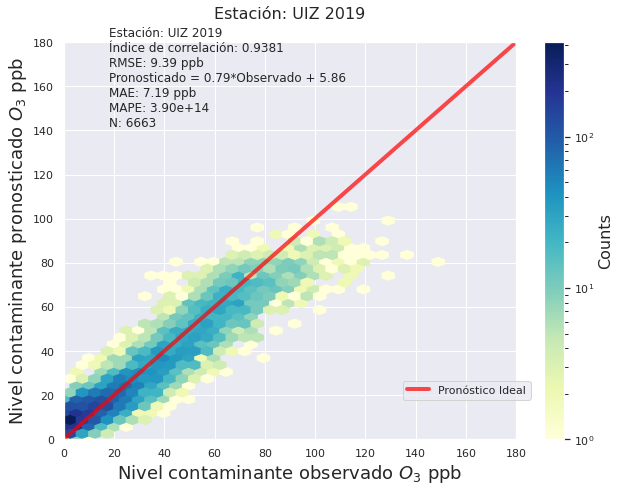

column name:plus_06_cont_otres_UIZ
Índice de correlación:                     0.8949


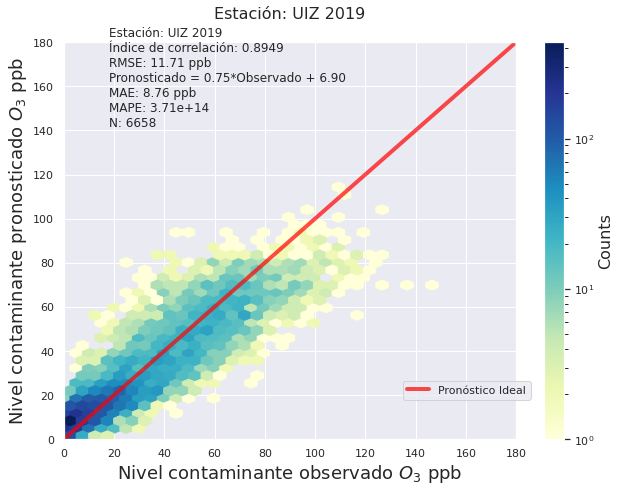

column name:plus_12_cont_otres_UIZ
Índice de correlación:                     0.8950


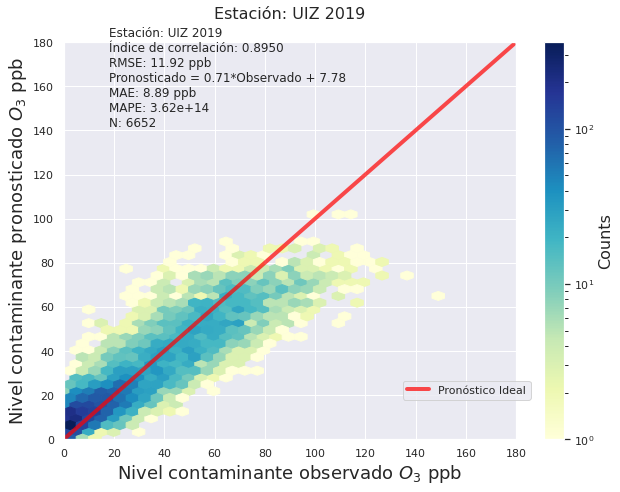

column name:plus_18_cont_otres_UIZ
Índice de correlación:                     0.8899


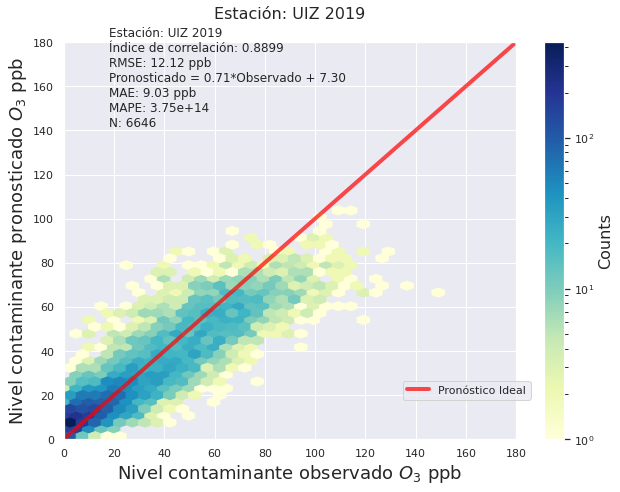

column name:plus_24_cont_otres_UIZ
Índice de correlación:                     0.8804


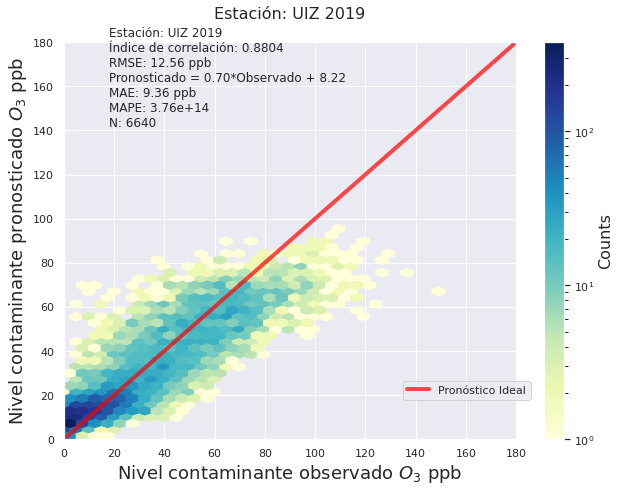

column name:plus_01_cont_otres_AJU
Índice de correlación:                     0.9045


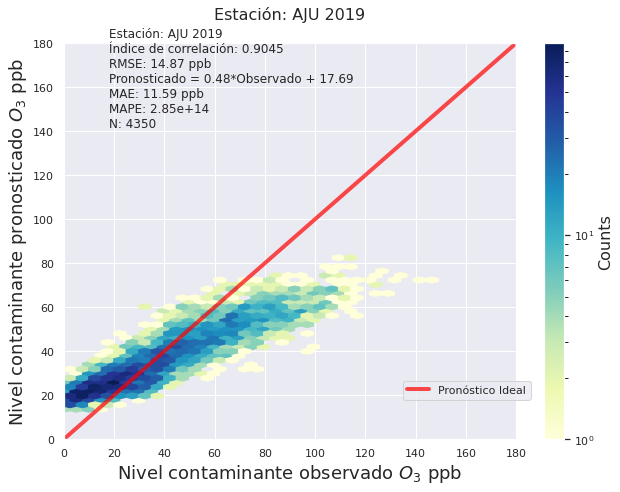

column name:plus_06_cont_otres_AJU
Índice de correlación:                     0.8699


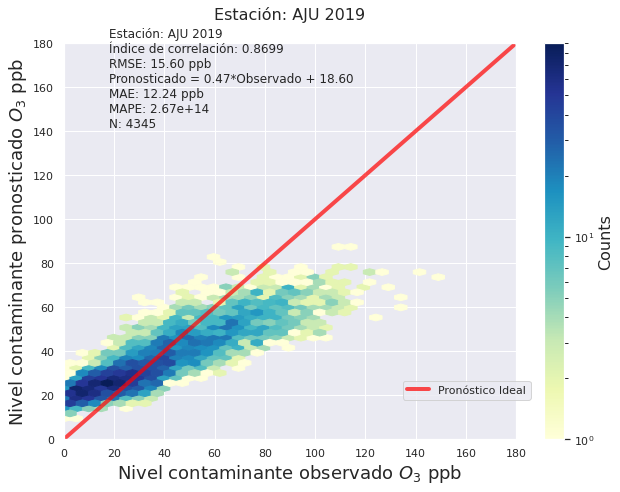

column name:plus_12_cont_otres_AJU
Índice de correlación:                     0.8581


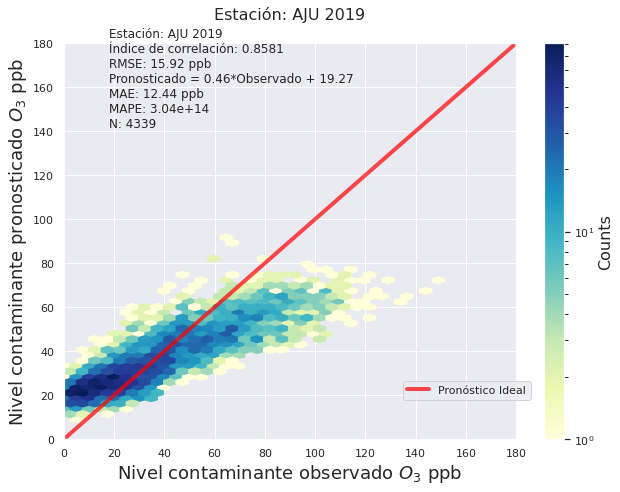

column name:plus_18_cont_otres_AJU
Índice de correlación:                     0.8588


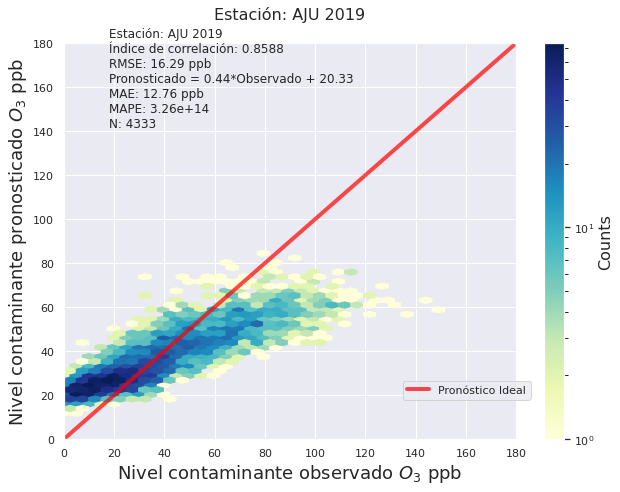

column name:plus_24_cont_otres_AJU
Índice de correlación:                     0.8413


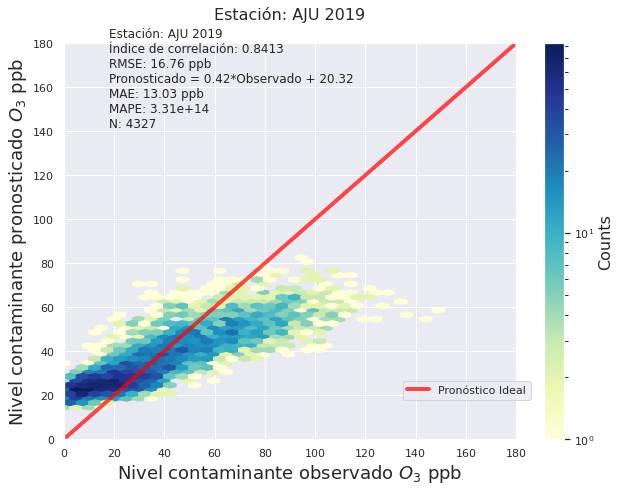

column name:plus_01_cont_otres_ATI
Índice de correlación:                     0.9265


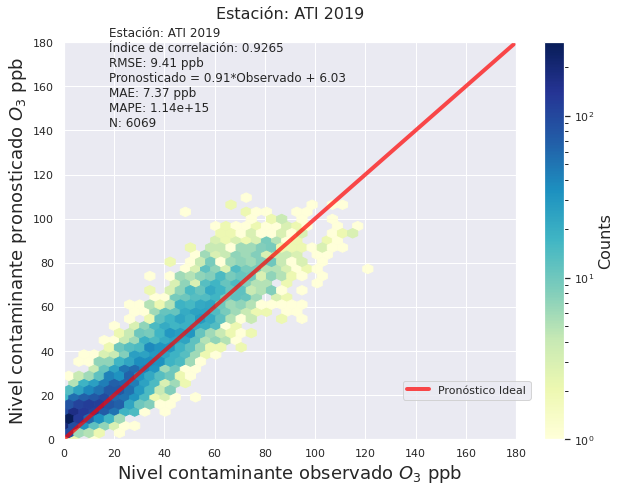

column name:plus_06_cont_otres_ATI
Índice de correlación:                     0.8835


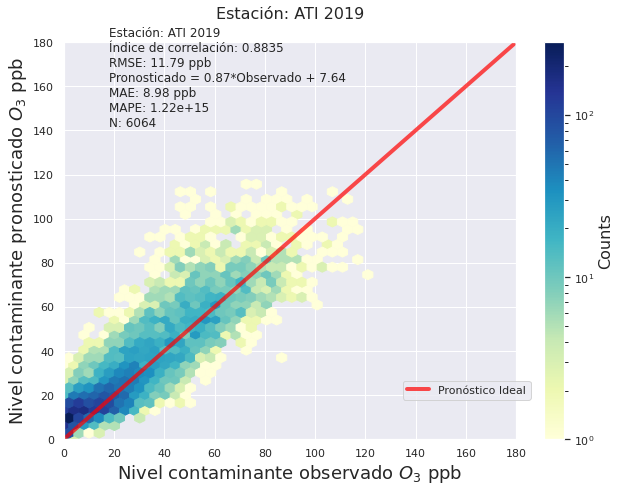

column name:plus_12_cont_otres_ATI
Índice de correlación:                     0.8809


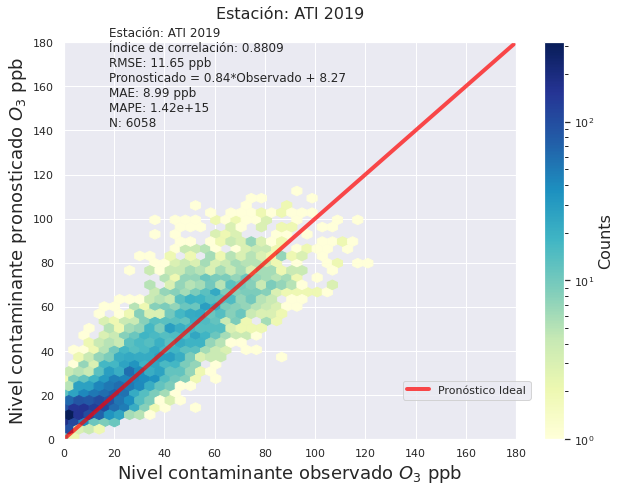

column name:plus_18_cont_otres_ATI
Índice de correlación:                     0.8838


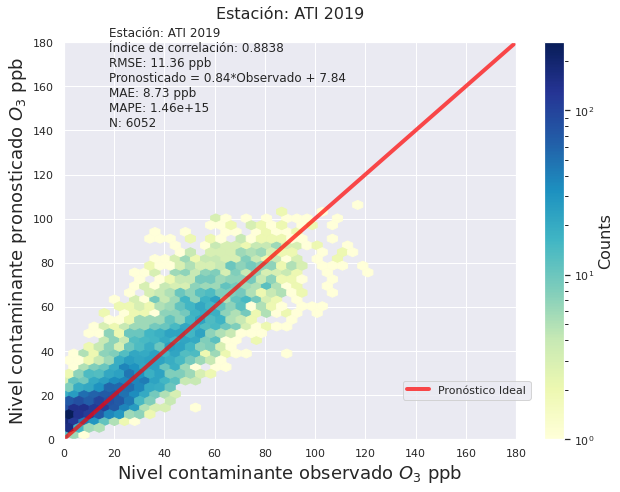

column name:plus_24_cont_otres_ATI
Índice de correlación:                     0.8764


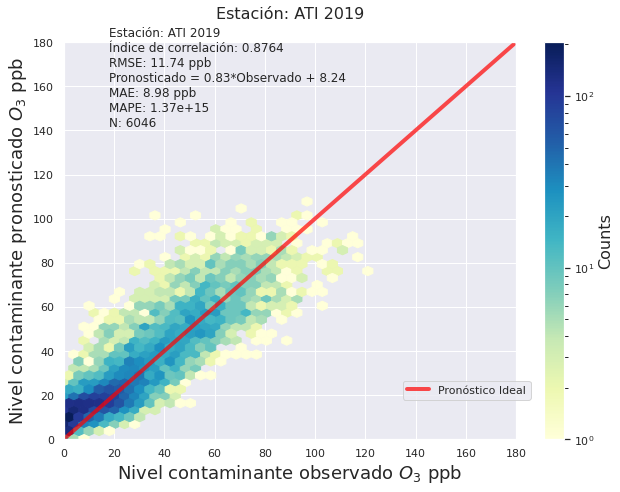

column name:plus_01_cont_otres_UAX
Índice de correlación:                     0.9076


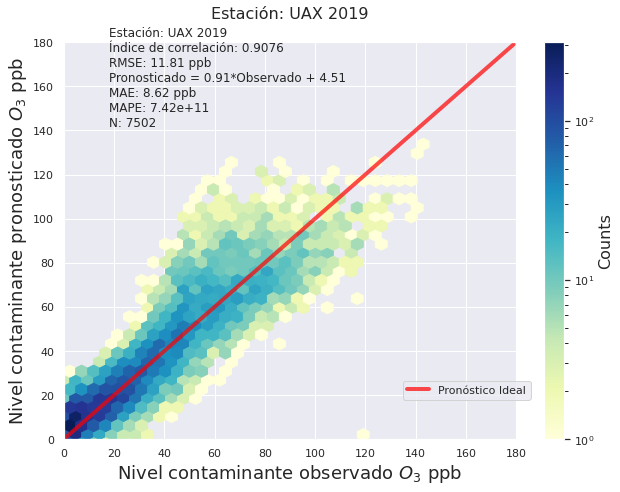

column name:plus_06_cont_otres_UAX
Índice de correlación:                     0.8772


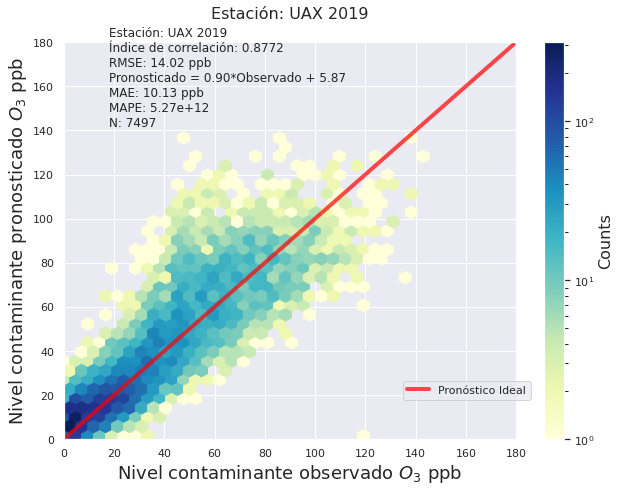

column name:plus_12_cont_otres_UAX
Índice de correlación:                     0.8681


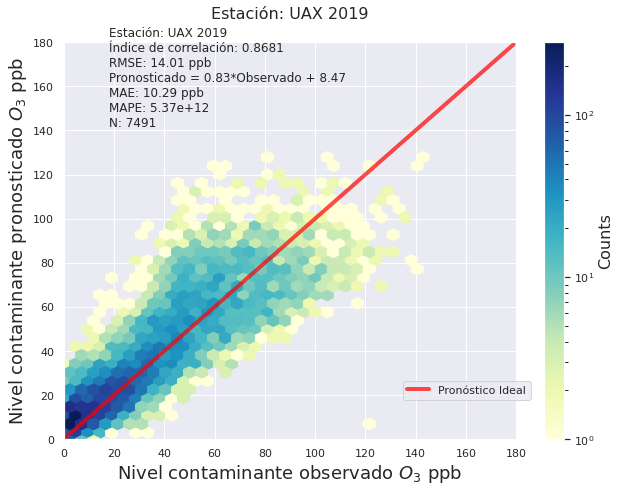

column name:plus_18_cont_otres_UAX
Índice de correlación:                     0.8628


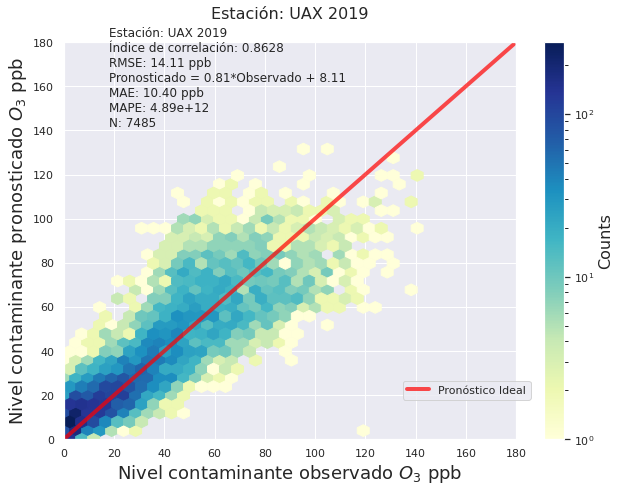

column name:plus_24_cont_otres_UAX
Índice de correlación:                     0.8573


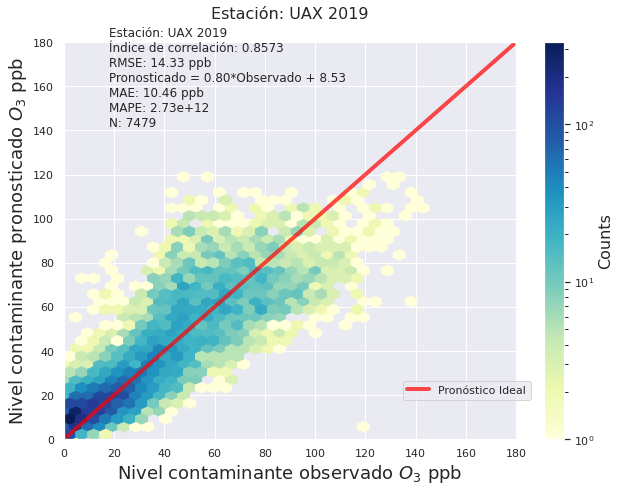

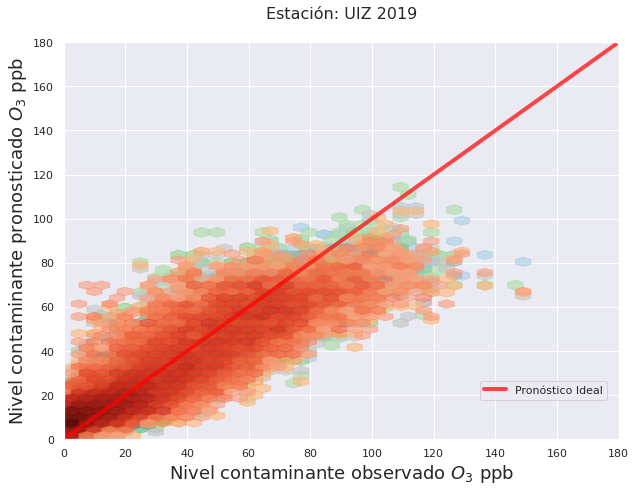

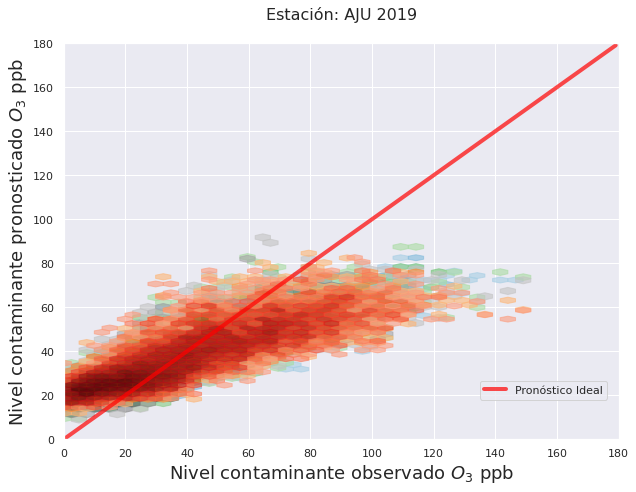

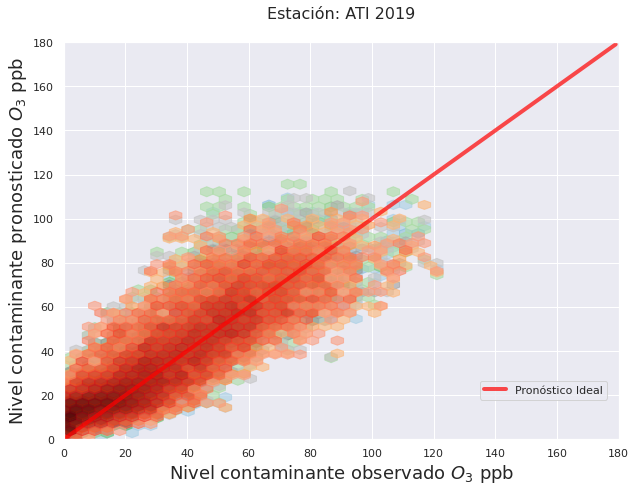

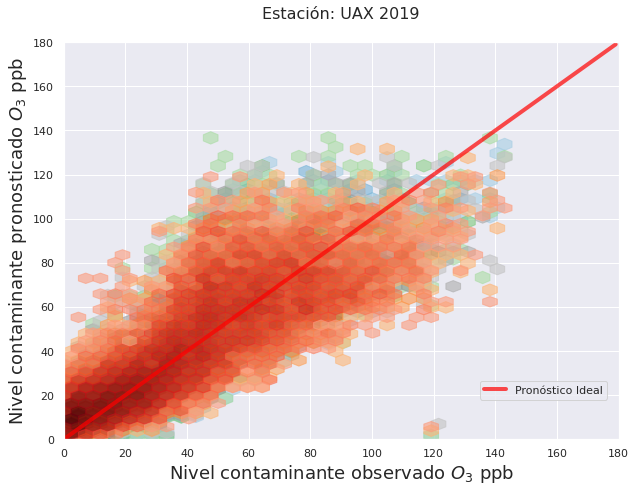

In [25]:
# %% *********** Chooses the proper model and weights ***********

# %% Loading csv with X an Y columns
X_cols_csv = pd.read_csv( join(path_csvs, 'X_columns.csv'))
Y_cols_csv = pd.read_csv( join(path_csvs, 'Y_columns.csv'))

X_cols = X_cols_csv['0'].tolist()
Y_cols = Y_cols_csv['0'].tolist()


# %% ******************* Selecting the model **********************

config[ModelParams.INPUT_SIZE] = INPUT_SIZE
config[ModelParams.NUMBER_OF_OUTPUT_CLASSES] = len(Y_cols)

print('Reading model ....')
model = select_1d_model(config)


# *********** Reads the weights***********
print('Reading weights ....')
model.load_weights(model_weights_file)


# %% Calculo de predicciones de el dataset de test:
Y_pred = model.predict(X_df.values)

# %% A funciton is defined to generate custom scaler objects
scaler_y = compile_scaler(scaler,Y_cols)


#%% Desescalar de predicciones y y_true, y su procesado
Y_pred_descaled = scaler_y.inverse_transform(Y_pred)
y_pred_descaled_df = pd.DataFrame(Y_pred_descaled,
                                  columns=scaler_y.feature_names_in_)
print(y_pred_descaled_df.head())

y_true_df = pd.DataFrame(scaler_y.inverse_transform(Y_df),
                         columns=Y_df.columns)
print(y_true_df.head())

# %% Evaluating only a set of stations and hours
for station in evaluate_stations:
    for hour in evaluate_hours:
        cur_column = f'plus_{hour:02}_cont_otres_{station}'
        print(f'column name:{cur_column}')
        # analyze_column(cur_column)
        analyze_column(cur_column,
                       y_pred_descaled_df,
                       y_true_df,
                       test_year=test_year,
                       output_results_folder_img=output_results_folder_img)

for station in evaluate_stations:
    analyze_multi_hour_plot(
        station,
        evaluate_hours,
        y_pred_descaled_df,
        y_true_df,
        test_year=test_year,
        output_results_folder_img=output_results_folder_img)



In [26]:
# %% #Crear DataFrame con resultados de métricas y guardar los resultados en csv

results_df = pd.DataFrame(columns=[
    "Columna", "Índice de correlación", "MAE", "MAPE", "MSE", "RMSE", "R2"
])

for cur_column in y_pred_descaled_df.columns:
    print(cur_column)
    column_results = analyze_column(cur_column,
                                    y_pred_descaled_df,
                                    y_true_df,
                                    test_year=test_year,
                                    generate_plot=False)
    results_df = results_df.append(column_results, ignore_index=True)

print(results_df)
results_df.to_csv(join(output_results_folder_data, 'results_df.csv'),
                  index=False)


plus_01_cont_otres_UIZ
Índice de correlación:                     0.9381
plus_01_cont_otres_AJU
Índice de correlación:                     0.9045
plus_01_cont_otres_ATI
Índice de correlación:                     0.9265
plus_01_cont_otres_CUA
Índice de correlación:                     0.8830
plus_01_cont_otres_SFE
Índice de correlación:                     0.9117
plus_01_cont_otres_SAG
Índice de correlación:                     0.9422
plus_01_cont_otres_CUT
Índice de correlación:                     0.9407
plus_01_cont_otres_PED
Índice de correlación:                     0.9416
plus_01_cont_otres_TAH
Índice de correlación:                     0.9172
plus_01_cont_otres_GAM
Índice de correlación:                     0.9362
plus_01_cont_otres_IZT
Índice de correlación:                     0.9526
plus_01_cont_otres_CCA
Índice de correlación:                     0.9412
plus_01_cont_otres_HGM
Índice de correlación:                     0.9409
plus_01_cont_otres_LPR
Índice de correlación:      

/tmp/ipykernel_1999599/4113888676.py:14: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  results_df = results_df.append(column_results, ignore_index=True)
/tmp/ipykernel_1999599/4113888676.py:14: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  results_df = results_df.append(column_results, ignore_index=True)
/tmp/ipykernel_1999599/4113888676.py:14: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  results_df = results_df.append(column_results, ignore_index=True)
/tmp/ipykernel_1999599/4113888676.py:14: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  results_df = results_df.append(column_results, ignore_index=True)
/tmp/ipykernel_1999599/411388867

Índice de correlación:                     0.9253
plus_02_cont_otres_CAM
Índice de correlación:                     0.9336
plus_02_cont_otres_FAC
Índice de correlación:                     0.9245
plus_02_cont_otres_TLA
Índice de correlación:                     0.9307
plus_02_cont_otres_MER
Índice de correlación:                     0.9386
plus_02_cont_otres_XAL
Índice de correlación:                     0.9193
plus_02_cont_otres_LLA
Índice de correlación:                     0.9286
plus_02_cont_otres_TLI
Índice de correlación:                     0.9296
plus_02_cont_otres_UAX
Índice de correlación:                     0.8921
plus_02_cont_otres_BJU
Índice de correlación:                     0.9207
plus_02_cont_otres_MPA
Índice de correlación:                     0.8690
plus_02_cont_otres_MON
Índice de correlación:                     0.9182
plus_02_cont_otres_NEZ
Índice de correlación:                     0.9152
plus_02_cont_otres_INN
Índice de correlación:                     0.8456
p

/tmp/ipykernel_1999599/4113888676.py:14: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  results_df = results_df.append(column_results, ignore_index=True)
/tmp/ipykernel_1999599/4113888676.py:14: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  results_df = results_df.append(column_results, ignore_index=True)
/tmp/ipykernel_1999599/4113888676.py:14: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  results_df = results_df.append(column_results, ignore_index=True)
/tmp/ipykernel_1999599/4113888676.py:14: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  results_df = results_df.append(column_results, ignore_index=True)
/tmp/ipykernel_1999599/411388867

Índice de correlación:                     0.9055
plus_04_cont_otres_AJU
Índice de correlación:                     0.8738
plus_04_cont_otres_ATI
Índice de correlación:                     0.8892
plus_04_cont_otres_CUA
Índice de correlación:                     0.8422
plus_04_cont_otres_SFE
Índice de correlación:                     0.8595
plus_04_cont_otres_SAG
Índice de correlación:                     0.9159
plus_04_cont_otres_CUT
Índice de correlación:                     0.9175
plus_04_cont_otres_PED
Índice de correlación:                     0.9020
plus_04_cont_otres_TAH
Índice de correlación:                     0.8891
plus_04_cont_otres_GAM
Índice de correlación:                     0.9020
plus_04_cont_otres_IZT
Índice de correlación:                     0.9124
plus_04_cont_otres_CCA
Índice de correlación:                     0.9031
plus_04_cont_otres_HGM
Índice de correlación:                     0.9075
plus_04_cont_otres_LPR
Índice de correlación:                     0.8726
p

/tmp/ipykernel_1999599/4113888676.py:14: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  results_df = results_df.append(column_results, ignore_index=True)
/tmp/ipykernel_1999599/4113888676.py:14: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  results_df = results_df.append(column_results, ignore_index=True)
/tmp/ipykernel_1999599/4113888676.py:14: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  results_df = results_df.append(column_results, ignore_index=True)
/tmp/ipykernel_1999599/4113888676.py:14: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  results_df = results_df.append(column_results, ignore_index=True)
/tmp/ipykernel_1999599/411388867

plus_05_cont_otres_TLA
Índice de correlación:                     0.8933
plus_05_cont_otres_MER
Índice de correlación:                     0.9024
plus_05_cont_otres_XAL
Índice de correlación:                     0.8936
plus_05_cont_otres_LLA
Índice de correlación:                     0.9027
plus_05_cont_otres_TLI
Índice de correlación:                     0.9023
plus_05_cont_otres_UAX
Índice de correlación:                     0.8798
plus_05_cont_otres_BJU
Índice de correlación:                     0.8864
plus_05_cont_otres_MPA
Índice de correlación:                     0.8424
plus_05_cont_otres_MON
Índice de correlación:                     0.8947
plus_05_cont_otres_NEZ
Índice de correlación:                     0.8931
plus_05_cont_otres_INN
Índice de correlación:                     0.8171
plus_05_cont_otres_AJM
Índice de correlación:                     0.8427
plus_05_cont_otres_VIF
Índice de correlación:                     0.8686
plus_06_cont_otres_UIZ
Índice de correlación:      

/tmp/ipykernel_1999599/4113888676.py:14: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  results_df = results_df.append(column_results, ignore_index=True)
/tmp/ipykernel_1999599/4113888676.py:14: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  results_df = results_df.append(column_results, ignore_index=True)
/tmp/ipykernel_1999599/4113888676.py:14: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  results_df = results_df.append(column_results, ignore_index=True)
/tmp/ipykernel_1999599/4113888676.py:14: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  results_df = results_df.append(column_results, ignore_index=True)
/tmp/ipykernel_1999599/411388867

plus_07_cont_otres_SAG
Índice de correlación:                     0.9087
plus_07_cont_otres_CUT
Índice de correlación:                     0.9110
plus_07_cont_otres_PED
Índice de correlación:                     0.8867
plus_07_cont_otres_TAH
Índice de correlación:                     0.8794
plus_07_cont_otres_GAM
Índice de correlación:                     0.8921
plus_07_cont_otres_IZT
Índice de correlación:                     0.8990
plus_07_cont_otres_CCA
Índice de correlación:                     0.8888
plus_07_cont_otres_HGM
Índice de correlación:                     0.8980
plus_07_cont_otres_LPR
Índice de correlación:                     0.8538
plus_07_cont_otres_MGH
Índice de correlación:                     0.8844
plus_07_cont_otres_CAM
Índice de correlación:                     0.8880
plus_07_cont_otres_FAC
Índice de correlación:                     0.8803
plus_07_cont_otres_TLA
Índice de correlación:                     0.8932
plus_07_cont_otres_MER
Índice de correlación:      

/tmp/ipykernel_1999599/4113888676.py:14: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  results_df = results_df.append(column_results, ignore_index=True)
/tmp/ipykernel_1999599/4113888676.py:14: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  results_df = results_df.append(column_results, ignore_index=True)
/tmp/ipykernel_1999599/4113888676.py:14: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  results_df = results_df.append(column_results, ignore_index=True)
/tmp/ipykernel_1999599/4113888676.py:14: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  results_df = results_df.append(column_results, ignore_index=True)
/tmp/ipykernel_1999599/411388867

plus_07_cont_otres_VIF
Índice de correlación:                     0.8684
plus_08_cont_otres_UIZ
Índice de correlación:                     0.8912
plus_08_cont_otres_AJU
Índice de correlación:                     0.8634
plus_08_cont_otres_ATI
Índice de correlación:                     0.8868
plus_08_cont_otres_CUA
Índice de correlación:                     0.8220
plus_08_cont_otres_SFE
Índice de correlación:                     0.8455
plus_08_cont_otres_SAG
Índice de correlación:                     0.9069
plus_08_cont_otres_CUT
Índice de correlación:                     0.9122
plus_08_cont_otres_PED
Índice de correlación:                     0.8861
plus_08_cont_otres_TAH
Índice de correlación:                     0.8795
plus_08_cont_otres_GAM
Índice de correlación:                     0.8952
plus_08_cont_otres_IZT
Índice de correlación:                     0.9005
plus_08_cont_otres_CCA
Índice de correlación:                     0.8896
plus_08_cont_otres_HGM
Índice de correlación:      

/tmp/ipykernel_1999599/4113888676.py:14: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  results_df = results_df.append(column_results, ignore_index=True)
/tmp/ipykernel_1999599/4113888676.py:14: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  results_df = results_df.append(column_results, ignore_index=True)
/tmp/ipykernel_1999599/4113888676.py:14: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  results_df = results_df.append(column_results, ignore_index=True)
/tmp/ipykernel_1999599/4113888676.py:14: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  results_df = results_df.append(column_results, ignore_index=True)
/tmp/ipykernel_1999599/411388867

Índice de correlación:                     0.8968
plus_09_cont_otres_IZT
Índice de correlación:                     0.8995
plus_09_cont_otres_CCA
Índice de correlación:                     0.8882
plus_09_cont_otres_HGM
Índice de correlación:                     0.8943
plus_09_cont_otres_LPR
Índice de correlación:                     0.8564
plus_09_cont_otres_MGH
Índice de correlación:                     0.8843
plus_09_cont_otres_CAM
Índice de correlación:                     0.8814
plus_09_cont_otres_FAC
Índice de correlación:                     0.8781
plus_09_cont_otres_TLA
Índice de correlación:                     0.8896
plus_09_cont_otres_MER
Índice de correlación:                     0.8975
plus_09_cont_otres_XAL
Índice de correlación:                     0.8897
plus_09_cont_otres_LLA
Índice de correlación:                     0.8972
plus_09_cont_otres_TLI
Índice de correlación:                     0.8933
plus_09_cont_otres_UAX
Índice de correlación:                     0.8719
p

/tmp/ipykernel_1999599/4113888676.py:14: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  results_df = results_df.append(column_results, ignore_index=True)
/tmp/ipykernel_1999599/4113888676.py:14: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  results_df = results_df.append(column_results, ignore_index=True)
/tmp/ipykernel_1999599/4113888676.py:14: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  results_df = results_df.append(column_results, ignore_index=True)
/tmp/ipykernel_1999599/4113888676.py:14: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  results_df = results_df.append(column_results, ignore_index=True)
/tmp/ipykernel_1999599/411388867

Índice de correlación:                     0.8947
plus_10_cont_otres_NEZ
Índice de correlación:                     0.8909
plus_10_cont_otres_INN
Índice de correlación:                     0.8102
plus_10_cont_otres_AJM
Índice de correlación:                     0.8359
plus_10_cont_otres_VIF
Índice de correlación:                     0.8589
plus_11_cont_otres_UIZ
Índice de correlación:                     0.8972
plus_11_cont_otres_AJU
Índice de correlación:                     0.8621
plus_11_cont_otres_ATI
Índice de correlación:                     0.8815
plus_11_cont_otres_CUA
Índice de correlación:                     0.8161
plus_11_cont_otres_SFE
Índice de correlación:                     0.8417
plus_11_cont_otres_SAG
Índice de correlación:                     0.9048
plus_11_cont_otres_CUT
Índice de correlación:                     0.9111
plus_11_cont_otres_PED
Índice de correlación:                     0.8889
plus_11_cont_otres_TAH
Índice de correlación:                     0.8789
p

/tmp/ipykernel_1999599/4113888676.py:14: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  results_df = results_df.append(column_results, ignore_index=True)
/tmp/ipykernel_1999599/4113888676.py:14: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  results_df = results_df.append(column_results, ignore_index=True)
/tmp/ipykernel_1999599/4113888676.py:14: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  results_df = results_df.append(column_results, ignore_index=True)
/tmp/ipykernel_1999599/4113888676.py:14: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  results_df = results_df.append(column_results, ignore_index=True)
/tmp/ipykernel_1999599/411388867

plus_12_cont_otres_HGM
Índice de correlación:                     0.8950
plus_12_cont_otres_LPR
Índice de correlación:                     0.8690
plus_12_cont_otres_MGH
Índice de correlación:                     0.8807
plus_12_cont_otres_CAM
Índice de correlación:                     0.8931
plus_12_cont_otres_FAC
Índice de correlación:                     0.8802
plus_12_cont_otres_TLA
Índice de correlación:                     0.8946
plus_12_cont_otres_MER
Índice de correlación:                     0.9005
plus_12_cont_otres_XAL
Índice de correlación:                     0.8891
plus_12_cont_otres_LLA
Índice de correlación:                     0.8990
plus_12_cont_otres_TLI
Índice de correlación:                     0.8984
plus_12_cont_otres_UAX
Índice de correlación:                     0.8681
plus_12_cont_otres_BJU
Índice de correlación:                     0.8782
plus_12_cont_otres_MPA
Índice de correlación:                     0.8284
plus_12_cont_otres_MON
Índice de correlación:      

/tmp/ipykernel_1999599/4113888676.py:14: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  results_df = results_df.append(column_results, ignore_index=True)
/tmp/ipykernel_1999599/4113888676.py:14: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  results_df = results_df.append(column_results, ignore_index=True)
/tmp/ipykernel_1999599/4113888676.py:14: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  results_df = results_df.append(column_results, ignore_index=True)
/tmp/ipykernel_1999599/4113888676.py:14: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  results_df = results_df.append(column_results, ignore_index=True)
/tmp/ipykernel_1999599/411388867

plus_13_cont_otres_VIF
Índice de correlación:                     0.8559
plus_14_cont_otres_UIZ
Índice de correlación:                     0.8899
plus_14_cont_otres_AJU
Índice de correlación:                     0.8483
plus_14_cont_otres_ATI
Índice de correlación:                     0.8815
plus_14_cont_otres_CUA
Índice de correlación:                     0.8178
plus_14_cont_otres_SFE
Índice de correlación:                     0.8465
plus_14_cont_otres_SAG
Índice de correlación:                     0.9044
plus_14_cont_otres_CUT
Índice de correlación:                     0.9074
plus_14_cont_otres_PED
Índice de correlación:                     0.8867
plus_14_cont_otres_TAH
Índice de correlación:                     0.8793
plus_14_cont_otres_GAM
Índice de correlación:                     0.8951
plus_14_cont_otres_IZT
Índice de correlación:                     0.9041
plus_14_cont_otres_CCA
Índice de correlación:                     0.8861
plus_14_cont_otres_HGM
Índice de correlación:      

/tmp/ipykernel_1999599/4113888676.py:14: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  results_df = results_df.append(column_results, ignore_index=True)
/tmp/ipykernel_1999599/4113888676.py:14: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  results_df = results_df.append(column_results, ignore_index=True)
/tmp/ipykernel_1999599/4113888676.py:14: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  results_df = results_df.append(column_results, ignore_index=True)
/tmp/ipykernel_1999599/4113888676.py:14: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  results_df = results_df.append(column_results, ignore_index=True)
/tmp/ipykernel_1999599/411388867

plus_15_cont_otres_CAM
Índice de correlación:                     0.8941
plus_15_cont_otres_FAC
Índice de correlación:                     0.8773
plus_15_cont_otres_TLA
Índice de correlación:                     0.8915
plus_15_cont_otres_MER
Índice de correlación:                     0.8991
plus_15_cont_otres_XAL
Índice de correlación:                     0.8865
plus_15_cont_otres_LLA
Índice de correlación:                     0.8968
plus_15_cont_otres_TLI
Índice de correlación:                     0.8971
plus_15_cont_otres_UAX
Índice de correlación:                     0.8655
plus_15_cont_otres_BJU
Índice de correlación:                     0.8787
plus_15_cont_otres_MPA
Índice de correlación:                     0.8238
plus_15_cont_otres_MON
Índice de correlación:                     0.8963
plus_15_cont_otres_NEZ
Índice de correlación:                     0.8849
plus_15_cont_otres_INN
Índice de correlación:                     0.7948
plus_15_cont_otres_AJM
Índice de correlación:      

/tmp/ipykernel_1999599/4113888676.py:14: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  results_df = results_df.append(column_results, ignore_index=True)
/tmp/ipykernel_1999599/4113888676.py:14: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  results_df = results_df.append(column_results, ignore_index=True)
/tmp/ipykernel_1999599/4113888676.py:14: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  results_df = results_df.append(column_results, ignore_index=True)
/tmp/ipykernel_1999599/4113888676.py:14: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  results_df = results_df.append(column_results, ignore_index=True)
/tmp/ipykernel_1999599/411388867

Índice de correlación:                     0.8848
plus_17_cont_otres_CUA
Índice de correlación:                     0.8156
plus_17_cont_otres_SFE
Índice de correlación:                     0.8386
plus_17_cont_otres_SAG
Índice de correlación:                     0.8989
plus_17_cont_otres_CUT
Índice de correlación:                     0.9114
plus_17_cont_otres_PED
Índice de correlación:                     0.8827
plus_17_cont_otres_TAH
Índice de correlación:                     0.8791
plus_17_cont_otres_GAM
Índice de correlación:                     0.8923
plus_17_cont_otres_IZT
Índice de correlación:                     0.8976
plus_17_cont_otres_CCA
Índice de correlación:                     0.8826
plus_17_cont_otres_HGM
Índice de correlación:                     0.8896
plus_17_cont_otres_LPR
Índice de correlación:                     0.8675
plus_17_cont_otres_MGH
Índice de correlación:                     0.8818
plus_17_cont_otres_CAM
Índice de correlación:                     0.8891
p

/tmp/ipykernel_1999599/4113888676.py:14: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  results_df = results_df.append(column_results, ignore_index=True)
/tmp/ipykernel_1999599/4113888676.py:14: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  results_df = results_df.append(column_results, ignore_index=True)
/tmp/ipykernel_1999599/4113888676.py:14: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  results_df = results_df.append(column_results, ignore_index=True)
/tmp/ipykernel_1999599/4113888676.py:14: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  results_df = results_df.append(column_results, ignore_index=True)
/tmp/ipykernel_1999599/411388867

plus_18_cont_otres_TLA
Índice de correlación:                     0.8895
plus_18_cont_otres_MER
Índice de correlación:                     0.8954
plus_18_cont_otres_XAL
Índice de correlación:                     0.8839
plus_18_cont_otres_LLA
Índice de correlación:                     0.8980
plus_18_cont_otres_TLI
Índice de correlación:                     0.8950
plus_18_cont_otres_UAX
Índice de correlación:                     0.8628
plus_18_cont_otres_BJU
Índice de correlación:                     0.8751
plus_18_cont_otres_MPA
Índice de correlación:                     0.8147
plus_18_cont_otres_MON
Índice de correlación:                     0.8928
plus_18_cont_otres_NEZ
Índice de correlación:                     0.8872
plus_18_cont_otres_INN
Índice de correlación:                     0.7876
plus_18_cont_otres_AJM
Índice de correlación:                     0.8253
plus_18_cont_otres_VIF
Índice de correlación:                     0.8584
plus_19_cont_otres_UIZ
Índice de correlación:      

/tmp/ipykernel_1999599/4113888676.py:14: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  results_df = results_df.append(column_results, ignore_index=True)
/tmp/ipykernel_1999599/4113888676.py:14: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  results_df = results_df.append(column_results, ignore_index=True)
/tmp/ipykernel_1999599/4113888676.py:14: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  results_df = results_df.append(column_results, ignore_index=True)
/tmp/ipykernel_1999599/4113888676.py:14: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  results_df = results_df.append(column_results, ignore_index=True)
/tmp/ipykernel_1999599/411388867

plus_19_cont_otres_NEZ
Índice de correlación:                     0.8878
plus_19_cont_otres_INN
Índice de correlación:                     0.7808
plus_19_cont_otres_AJM
Índice de correlación:                     0.8233
plus_19_cont_otres_VIF
Índice de correlación:                     0.8538
plus_20_cont_otres_UIZ
Índice de correlación:                     0.8860
plus_20_cont_otres_AJU
Índice de correlación:                     0.8549
plus_20_cont_otres_ATI
Índice de correlación:                     0.8805
plus_20_cont_otres_CUA
Índice de correlación:                     0.8161
plus_20_cont_otres_SFE
Índice de correlación:                     0.8335
plus_20_cont_otres_SAG
Índice de correlación:                     0.8998
plus_20_cont_otres_CUT
Índice de correlación:                     0.9085
plus_20_cont_otres_PED
Índice de correlación:                     0.8819
plus_20_cont_otres_TAH
Índice de correlación:                     0.8730
plus_20_cont_otres_GAM
Índice de correlación:      

/tmp/ipykernel_1999599/4113888676.py:14: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  results_df = results_df.append(column_results, ignore_index=True)
/tmp/ipykernel_1999599/4113888676.py:14: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  results_df = results_df.append(column_results, ignore_index=True)
/tmp/ipykernel_1999599/4113888676.py:14: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  results_df = results_df.append(column_results, ignore_index=True)
/tmp/ipykernel_1999599/4113888676.py:14: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  results_df = results_df.append(column_results, ignore_index=True)
/tmp/ipykernel_1999599/411388867

plus_21_cont_otres_HGM
Índice de correlación:                     0.8859
plus_21_cont_otres_LPR
Índice de correlación:                     0.8539
plus_21_cont_otres_MGH
Índice de correlación:                     0.8798
plus_21_cont_otres_CAM
Índice de correlación:                     0.8812
plus_21_cont_otres_FAC
Índice de correlación:                     0.8699
plus_21_cont_otres_TLA
Índice de correlación:                     0.8896
plus_21_cont_otres_MER
Índice de correlación:                     0.8893
plus_21_cont_otres_XAL
Índice de correlación:                     0.8781
plus_21_cont_otres_LLA
Índice de correlación:                     0.8967
plus_21_cont_otres_TLI
Índice de correlación:                     0.8925
plus_21_cont_otres_UAX
Índice de correlación:                     0.8601
plus_21_cont_otres_BJU
Índice de correlación:                     0.8767
plus_21_cont_otres_MPA
Índice de correlación:                     0.8101
plus_21_cont_otres_MON
Índice de correlación:      

/tmp/ipykernel_1999599/4113888676.py:14: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  results_df = results_df.append(column_results, ignore_index=True)
/tmp/ipykernel_1999599/4113888676.py:14: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  results_df = results_df.append(column_results, ignore_index=True)
/tmp/ipykernel_1999599/4113888676.py:14: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  results_df = results_df.append(column_results, ignore_index=True)
/tmp/ipykernel_1999599/4113888676.py:14: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  results_df = results_df.append(column_results, ignore_index=True)
/tmp/ipykernel_1999599/411388867

plus_22_cont_otres_VIF
Índice de correlación:                     0.8566
plus_23_cont_otres_UIZ
Índice de correlación:                     0.8821
plus_23_cont_otres_AJU
Índice de correlación:                     0.8454
plus_23_cont_otres_ATI
Índice de correlación:                     0.8776
plus_23_cont_otres_CUA
Índice de correlación:                     0.8169
plus_23_cont_otres_SFE
Índice de correlación:                     0.8382
plus_23_cont_otres_SAG
Índice de correlación:                     0.8977
plus_23_cont_otres_CUT
Índice de correlación:                     0.9074
plus_23_cont_otres_PED
Índice de correlación:                     0.8716
plus_23_cont_otres_TAH
Índice de correlación:                     0.8723
plus_23_cont_otres_GAM
Índice de correlación:                     0.8833
plus_23_cont_otres_IZT
Índice de correlación:                     0.8963
plus_23_cont_otres_CCA
Índice de correlación:                     0.8714
plus_23_cont_otres_HGM
Índice de correlación:      

/tmp/ipykernel_1999599/4113888676.py:14: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  results_df = results_df.append(column_results, ignore_index=True)
/tmp/ipykernel_1999599/4113888676.py:14: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  results_df = results_df.append(column_results, ignore_index=True)
/tmp/ipykernel_1999599/4113888676.py:14: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  results_df = results_df.append(column_results, ignore_index=True)
/tmp/ipykernel_1999599/4113888676.py:14: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  results_df = results_df.append(column_results, ignore_index=True)
/tmp/ipykernel_1999599/411388867

plus_24_cont_otres_FAC
Índice de correlación:                     0.8711
plus_24_cont_otres_TLA
Índice de correlación:                     0.8896
plus_24_cont_otres_MER
Índice de correlación:                     0.8858
plus_24_cont_otres_XAL
Índice de correlación:                     0.8724
plus_24_cont_otres_LLA
Índice de correlación:                     0.8934
plus_24_cont_otres_TLI
Índice de correlación:                     0.8892
plus_24_cont_otres_UAX
Índice de correlación:                     0.8573
plus_24_cont_otres_BJU
Índice de correlación:                     0.8691
plus_24_cont_otres_MPA
Índice de correlación:                     0.8076
plus_24_cont_otres_MON
Índice de correlación:                     0.8891
plus_24_cont_otres_NEZ
Índice de correlación:                     0.8800
plus_24_cont_otres_INN
Índice de correlación:                     0.7740
plus_24_cont_otres_AJM
Índice de correlación:                     0.8123
plus_24_cont_otres_VIF
Índice de correlación:      

/tmp/ipykernel_1999599/4113888676.py:14: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  results_df = results_df.append(column_results, ignore_index=True)
/tmp/ipykernel_1999599/4113888676.py:14: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  results_df = results_df.append(column_results, ignore_index=True)
/tmp/ipykernel_1999599/4113888676.py:14: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  results_df = results_df.append(column_results, ignore_index=True)
/tmp/ipykernel_1999599/4113888676.py:14: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  results_df = results_df.append(column_results, ignore_index=True)
/tmp/ipykernel_1999599/411388867

In [27]:
results_df
# Extract unique station identifiers from the "Columna" column
station_identifiers = results_df['Columna'].str.split('_').str[4].unique()
station_identifiers

array(['UIZ', 'AJU', 'ATI', 'CUA', 'SFE', 'SAG', 'CUT', 'PED', 'TAH',
       'GAM', 'IZT', 'CCA', 'HGM', 'LPR', 'MGH', 'CAM', 'FAC', 'TLA',
       'MER', 'XAL', 'LLA', 'TLI', 'UAX', 'BJU', 'MPA', 'MON', 'NEZ',
       'INN', 'AJM', 'VIF'], dtype=object)

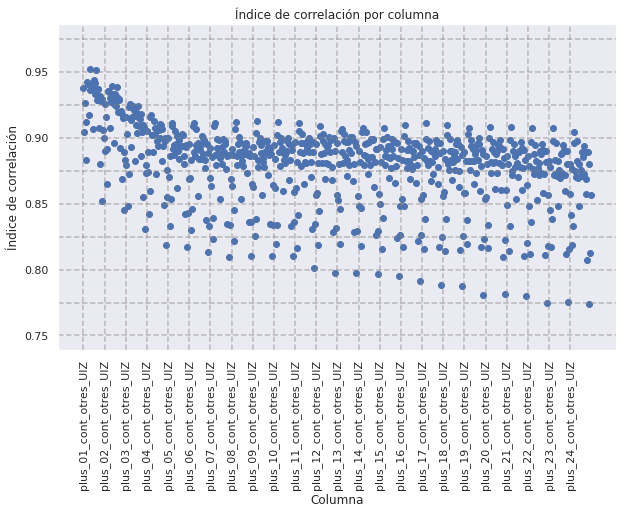

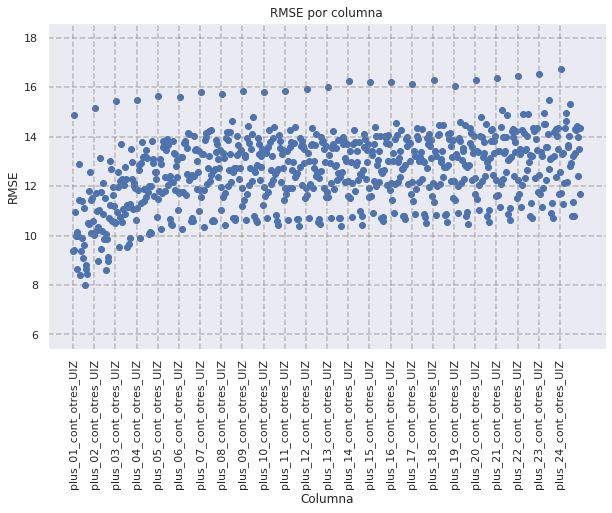

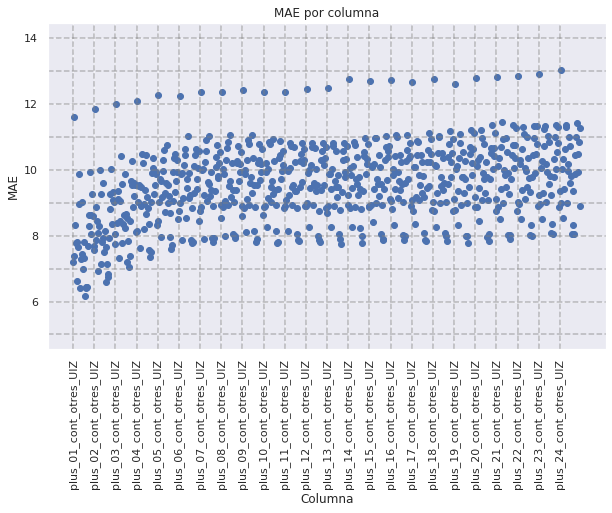

In [28]:
# %% Scatter plot for the given metrics

scatter_plot_by_column(results_df, 'Índice de correlación',
                output_results_folder_img)
scatter_plot_by_column(results_df, 'RMSE', output_results_folder_img)
scatter_plot_by_column(results_df, 'MAE', output_results_folder_img)


/OZONO/HOME/pedro/git2/otro6/air_pollution_forecast/proj_prediction/prediction.py:411: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  average_metrics_df = average_metrics_df.append({'Station': station, metric: average_metric_value}, ignore_index=True)
/OZONO/HOME/pedro/git2/otro6/air_pollution_forecast/proj_prediction/prediction.py:411: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  average_metrics_df = average_metrics_df.append({'Station': station, metric: average_metric_value}, ignore_index=True)
/OZONO/HOME/pedro/git2/otro6/air_pollution_forecast/proj_prediction/prediction.py:411: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  average_metrics_df = average_metrics_df.append({'Station': station, metric: average_metric_value},

Promedio general de Índice de correlación sobre todas las estaciones: 0.8798


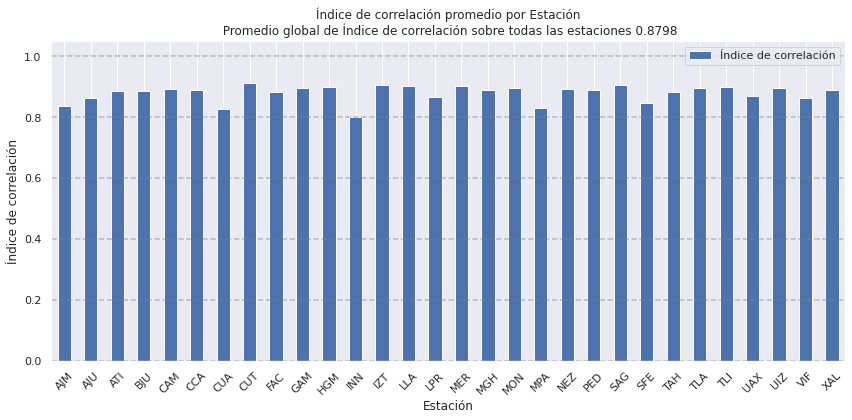

/OZONO/HOME/pedro/git2/otro6/air_pollution_forecast/proj_prediction/prediction.py:411: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  average_metrics_df = average_metrics_df.append({'Station': station, metric: average_metric_value}, ignore_index=True)
/OZONO/HOME/pedro/git2/otro6/air_pollution_forecast/proj_prediction/prediction.py:411: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  average_metrics_df = average_metrics_df.append({'Station': station, metric: average_metric_value}, ignore_index=True)
/OZONO/HOME/pedro/git2/otro6/air_pollution_forecast/proj_prediction/prediction.py:411: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  average_metrics_df = average_metrics_df.append({'Station': station, metric: average_metric_value},

Promedio general de RMSE sobre todas las estaciones: 12.6100


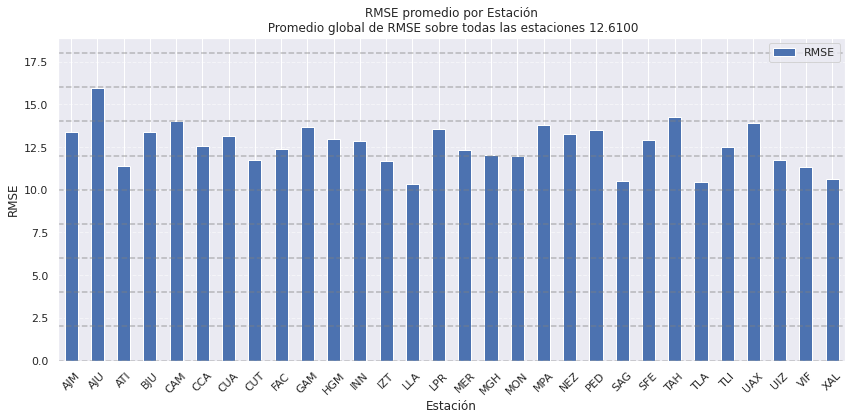

/OZONO/HOME/pedro/git2/otro6/air_pollution_forecast/proj_prediction/prediction.py:411: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  average_metrics_df = average_metrics_df.append({'Station': station, metric: average_metric_value}, ignore_index=True)
/OZONO/HOME/pedro/git2/otro6/air_pollution_forecast/proj_prediction/prediction.py:411: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  average_metrics_df = average_metrics_df.append({'Station': station, metric: average_metric_value}, ignore_index=True)
/OZONO/HOME/pedro/git2/otro6/air_pollution_forecast/proj_prediction/prediction.py:411: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  average_metrics_df = average_metrics_df.append({'Station': station, metric: average_metric_value},

Promedio general de MAE sobre todas las estaciones: 9.5547


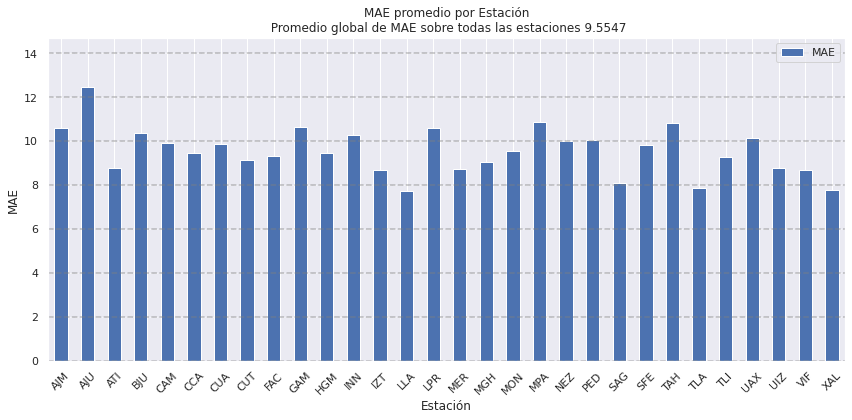

In [29]:
# %% Llamada a función para graficar las métricas de resumen de todas horas por estacion

average_metric(results_df, 'Índice de correlación', output_results_folder_img)
average_metric(results_df, 'RMSE', output_results_folder_img)
average_metric(results_df, 'MAE', output_results_folder_img)

/OZONO/HOME/pedro/git2/otro6/air_pollution_forecast/proj_prediction/prediction.py:445: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  average_metrics_df = average_metrics_df.append(
/OZONO/HOME/pedro/git2/otro6/air_pollution_forecast/proj_prediction/prediction.py:445: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  average_metrics_df = average_metrics_df.append(
/OZONO/HOME/pedro/git2/otro6/air_pollution_forecast/proj_prediction/prediction.py:445: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  average_metrics_df = average_metrics_df.append(
/OZONO/HOME/pedro/git2/otro6/air_pollution_forecast/proj_prediction/prediction.py:445: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future versio

Promedio general de Índice de correlación sobre todas las horas: 0.8798


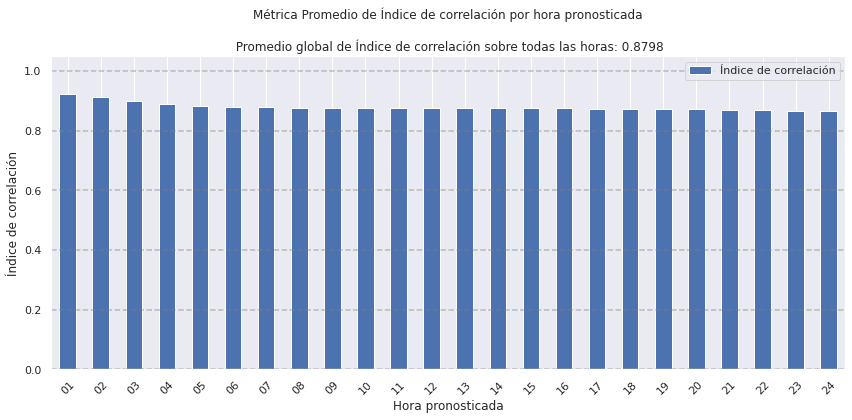

/OZONO/HOME/pedro/git2/otro6/air_pollution_forecast/proj_prediction/prediction.py:445: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  average_metrics_df = average_metrics_df.append(
/OZONO/HOME/pedro/git2/otro6/air_pollution_forecast/proj_prediction/prediction.py:445: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  average_metrics_df = average_metrics_df.append(
/OZONO/HOME/pedro/git2/otro6/air_pollution_forecast/proj_prediction/prediction.py:445: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  average_metrics_df = average_metrics_df.append(
/OZONO/HOME/pedro/git2/otro6/air_pollution_forecast/proj_prediction/prediction.py:445: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future versio

Promedio general de RMSE sobre todas las horas: 12.6100


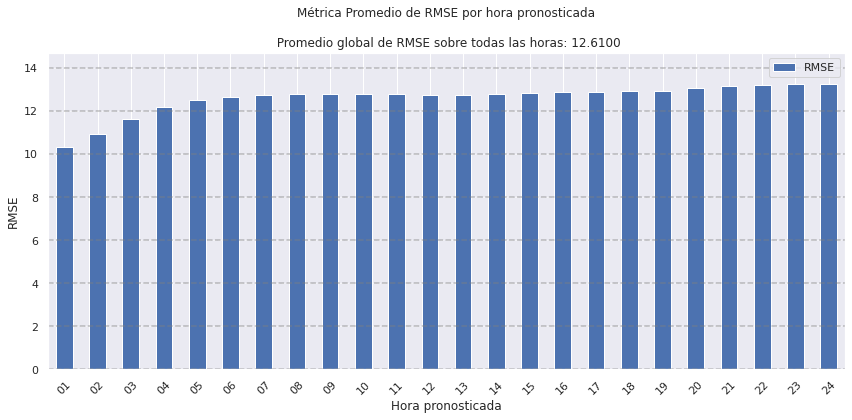

/OZONO/HOME/pedro/git2/otro6/air_pollution_forecast/proj_prediction/prediction.py:445: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  average_metrics_df = average_metrics_df.append(
/OZONO/HOME/pedro/git2/otro6/air_pollution_forecast/proj_prediction/prediction.py:445: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  average_metrics_df = average_metrics_df.append(
/OZONO/HOME/pedro/git2/otro6/air_pollution_forecast/proj_prediction/prediction.py:445: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  average_metrics_df = average_metrics_df.append(
/OZONO/HOME/pedro/git2/otro6/air_pollution_forecast/proj_prediction/prediction.py:445: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future versio

Promedio general de MAE sobre todas las horas: 9.5547


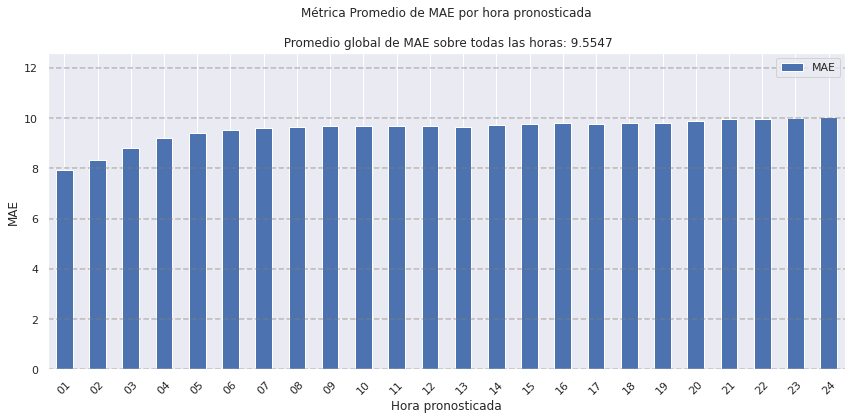

In [30]:
# %% Llamada a función para graficar las métricas de resumen de todas las estaciones por hora
average_metric_by_hour(results_df, 'Índice de correlación', output_results_folder_img)
average_metric_by_hour(results_df, 'RMSE', output_results_folder_img)
average_metric_by_hour(results_df, 'MAE', output_results_folder_img)

In [31]:
# %% 
params_grid = [(f'plus_{hour:02}_cont_{cur_pollutant}_{cur_station}')
               for cur_station in evaluate_stations for hour in evaluate_hours]


plus_01_cont_otres_UIZ


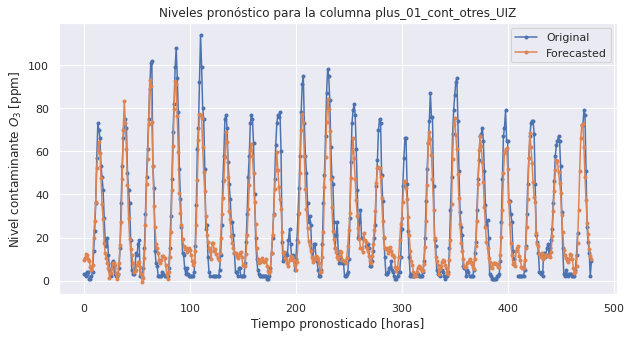

plus_06_cont_otres_UIZ


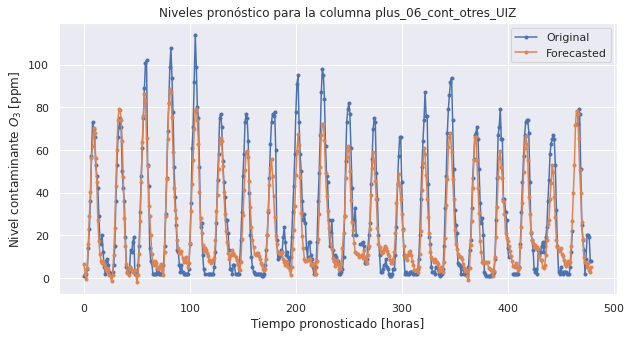

plus_12_cont_otres_UIZ


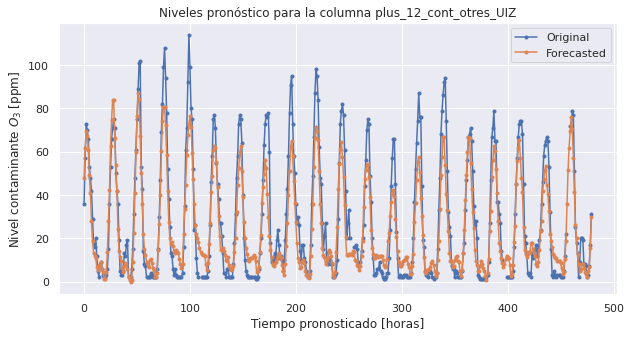

plus_18_cont_otres_UIZ


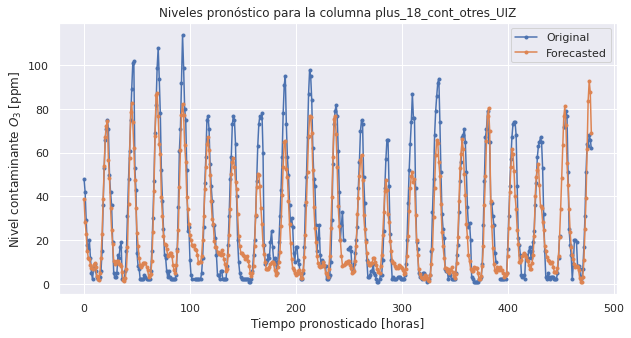

plus_24_cont_otres_UIZ


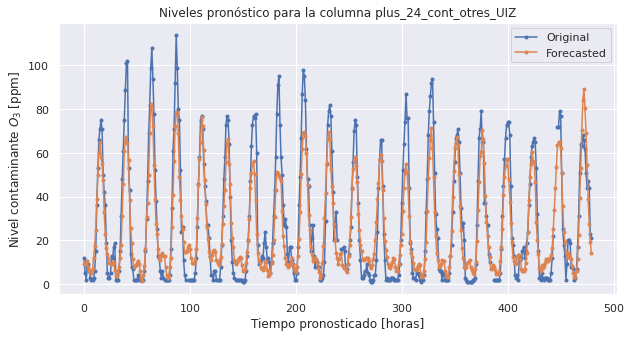

plus_01_cont_otres_AJU


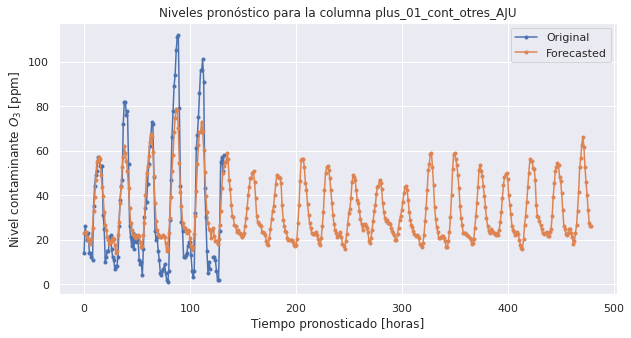

plus_06_cont_otres_AJU


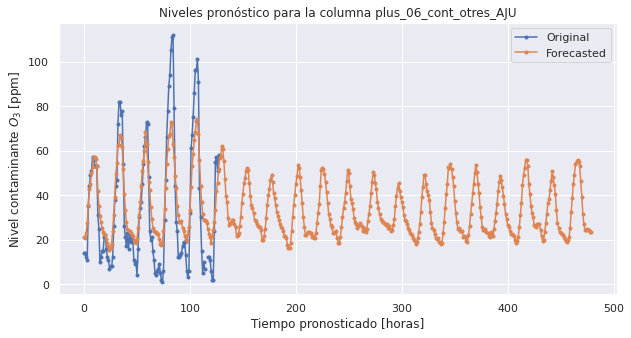

plus_12_cont_otres_AJU


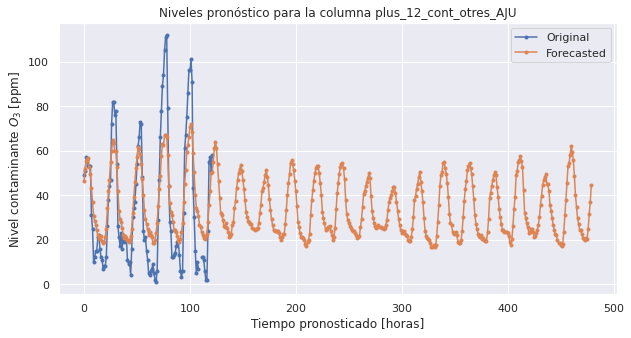

plus_18_cont_otres_AJU


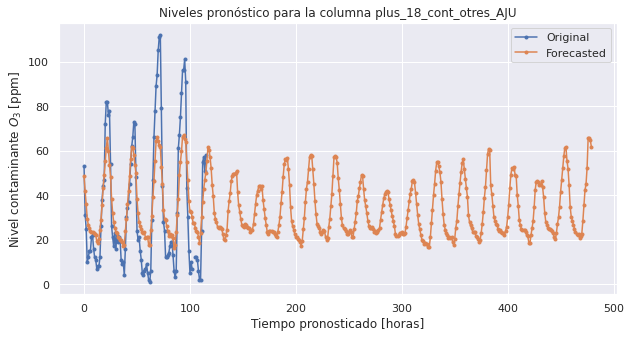

plus_24_cont_otres_AJU


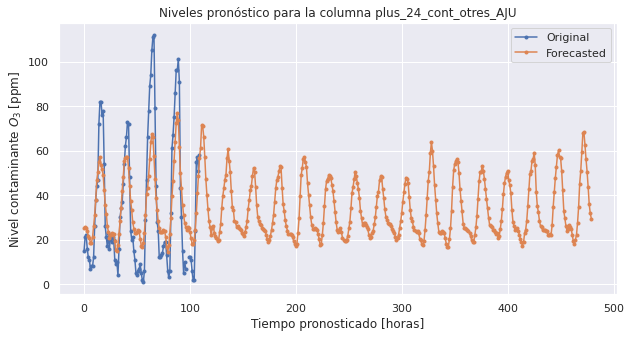

plus_01_cont_otres_ATI


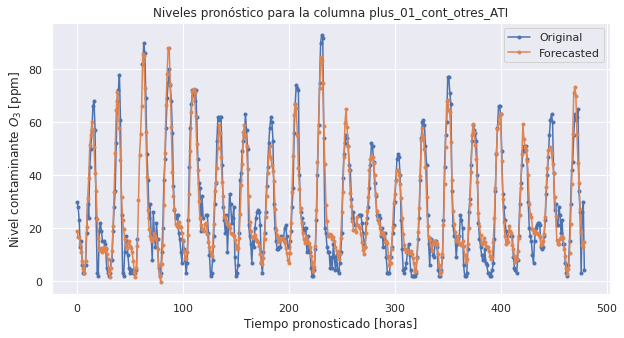

plus_06_cont_otres_ATI


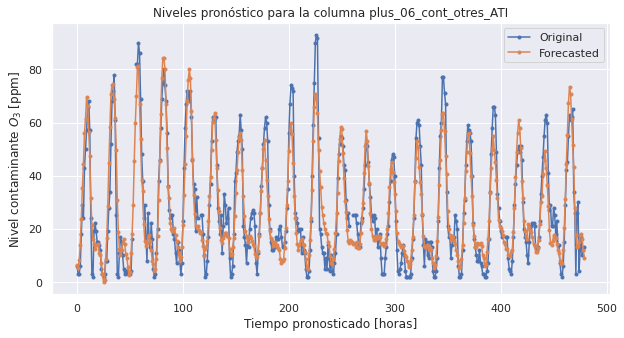

plus_12_cont_otres_ATI


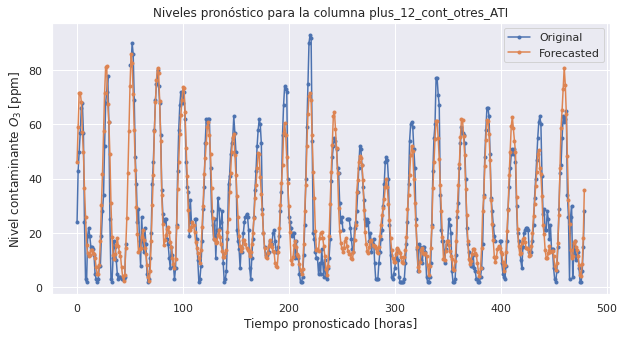

plus_18_cont_otres_ATI


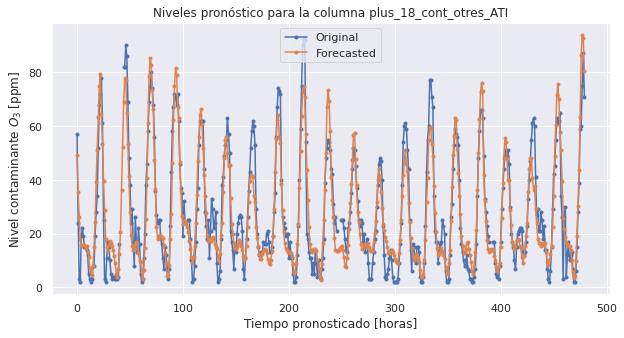

plus_24_cont_otres_ATI


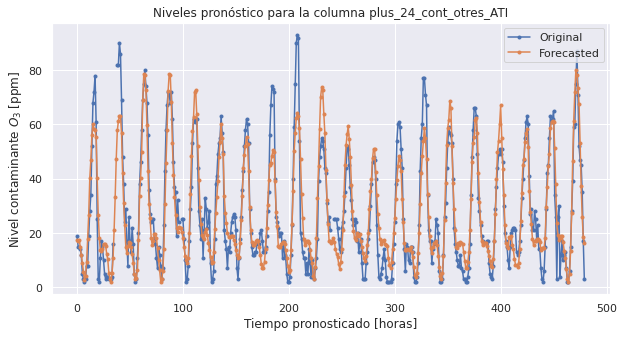

plus_01_cont_otres_UAX


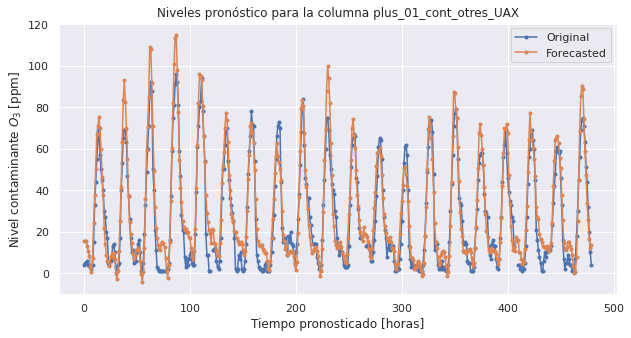

plus_06_cont_otres_UAX


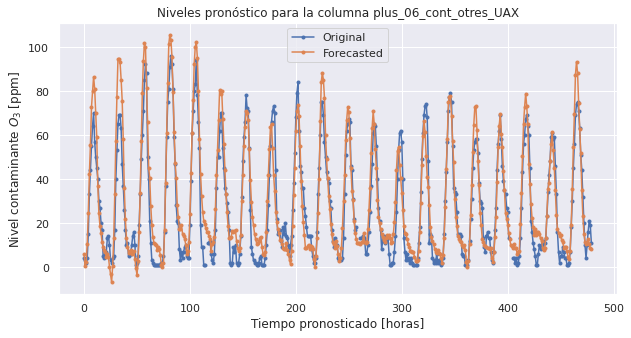

plus_12_cont_otres_UAX


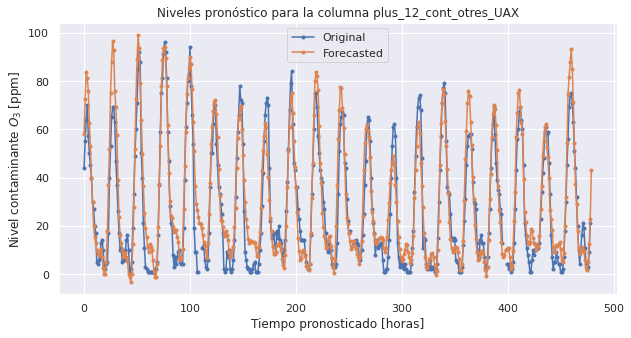

plus_18_cont_otres_UAX


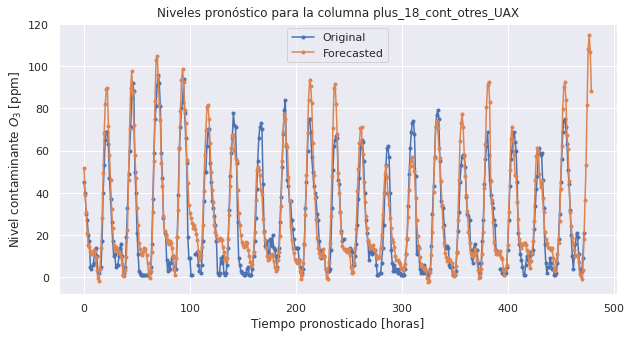

plus_24_cont_otres_UAX


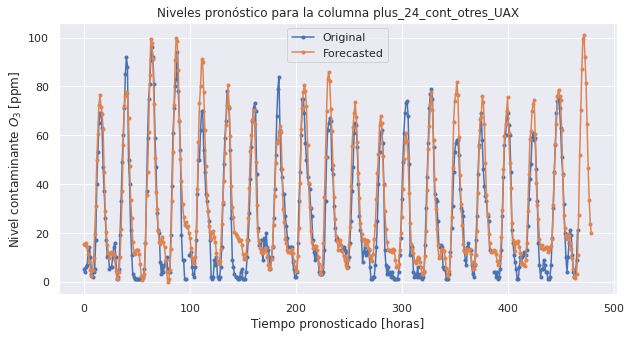

In [32]:
# %% #Hacer gráficas de horas de algunos casos
for cur_column in params_grid:
    print(cur_column)
    # Llamar a la función con la columna deseada
    plot_forecast_hours(cur_column, y_true_df,
                        y_pred_descaled_df)  # , path_home)

plus_01_cont_otres_UIZ
Error promedio al comparar valores máximos cada 24 hrs: 4.460710824546167
Desviación estándar de diferencia en valores máximos diarios: 13.149686857525953


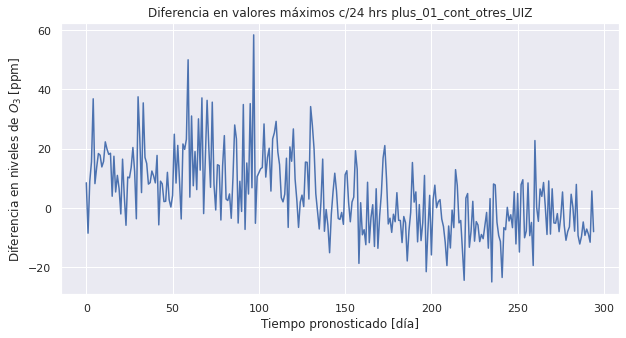

plus_06_cont_otres_UIZ
Error promedio al comparar valores máximos cada 24 hrs: 4.613848928677833
Desviación estándar de diferencia en valores máximos diarios: 16.654513445040795


/tmp/ipykernel_1999599/3620498831.py:13: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  results_max_df = results_max_df.append(


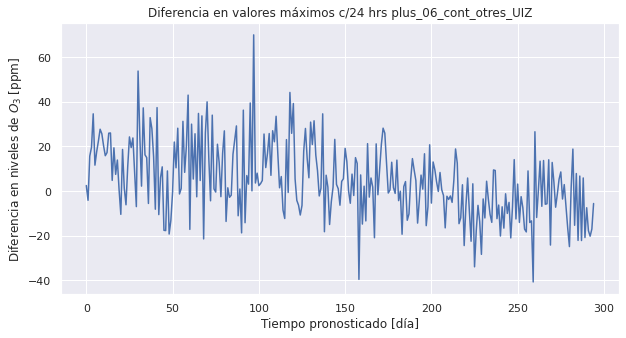

/tmp/ipykernel_1999599/3620498831.py:13: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  results_max_df = results_max_df.append(


plus_12_cont_otres_UIZ
Error promedio al comparar valores máximos cada 24 hrs: 8.728944912403323
Desviación estándar de diferencia en valores máximos diarios: 16.4496483065756


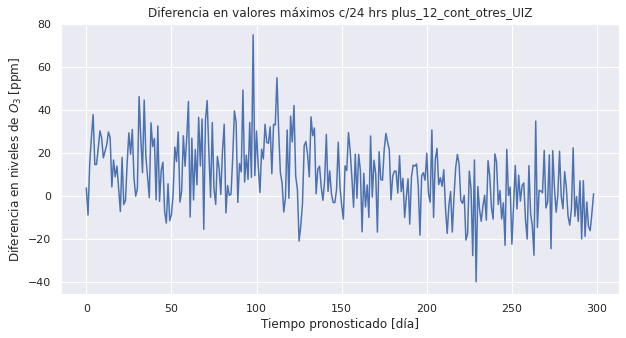

/tmp/ipykernel_1999599/3620498831.py:13: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  results_max_df = results_max_df.append(


plus_18_cont_otres_UIZ
Error promedio al comparar valores máximos cada 24 hrs: 7.984613946966223
Desviación estándar de diferencia en valores máximos diarios: 17.30186720485157


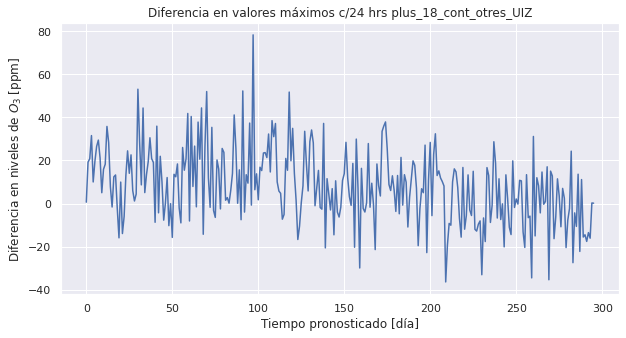

/tmp/ipykernel_1999599/3620498831.py:13: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  results_max_df = results_max_df.append(


plus_24_cont_otres_UIZ
Error promedio al comparar valores máximos cada 24 hrs: 7.750513524425273
Desviación estándar de diferencia en valores máximos diarios: 18.319000581367483


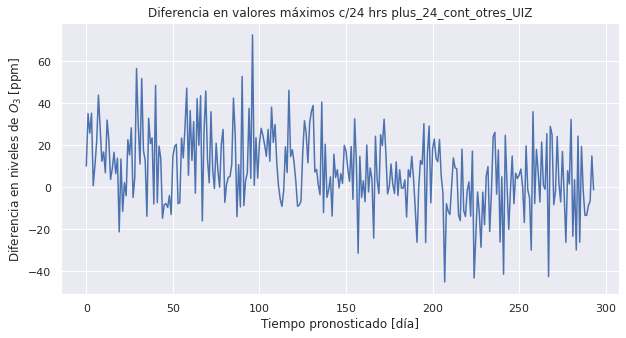

/tmp/ipykernel_1999599/3620498831.py:13: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  results_max_df = results_max_df.append(


plus_01_cont_otres_AJU
Error promedio al comparar valores máximos cada 24 hrs: 18.63933978361242
Desviación estándar de diferencia en valores máximos diarios: 17.70660436797239


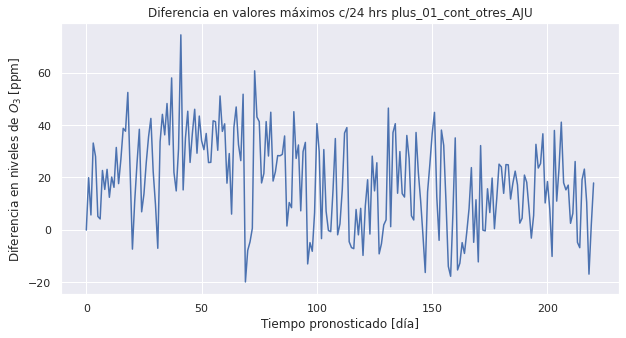

/tmp/ipykernel_1999599/3620498831.py:13: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  results_max_df = results_max_df.append(


plus_06_cont_otres_AJU
Error promedio al comparar valores máximos cada 24 hrs: 17.579517716760034
Desviación estándar de diferencia en valores máximos diarios: 19.236145683092452


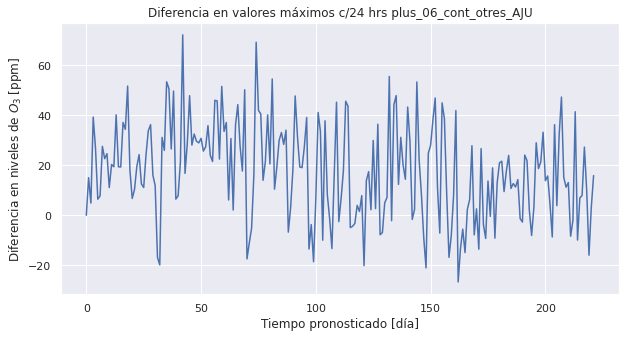

/tmp/ipykernel_1999599/3620498831.py:13: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  results_max_df = results_max_df.append(


plus_12_cont_otres_AJU
Error promedio al comparar valores máximos cada 24 hrs: 19.14844813647571
Desviación estándar de diferencia en valores máximos diarios: 19.028482118400458


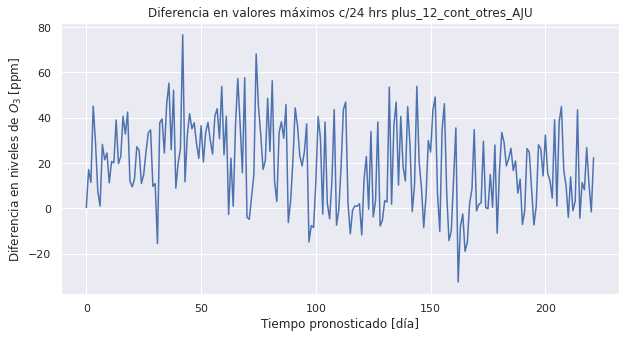

/tmp/ipykernel_1999599/3620498831.py:13: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  results_max_df = results_max_df.append(


plus_18_cont_otres_AJU
Error promedio al comparar valores máximos cada 24 hrs: 20.245128207736546
Desviación estándar de diferencia en valores máximos diarios: 20.224118830583524


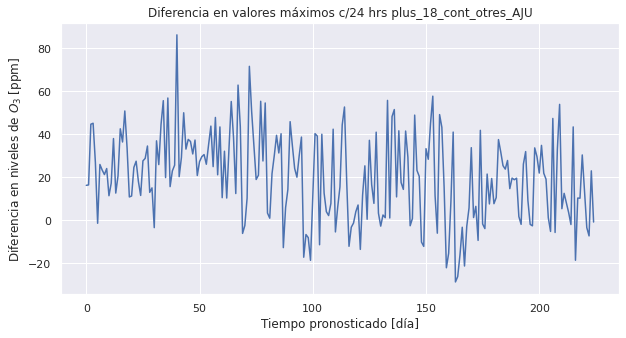

/tmp/ipykernel_1999599/3620498831.py:13: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  results_max_df = results_max_df.append(


plus_24_cont_otres_AJU
Error promedio al comparar valores máximos cada 24 hrs: 18.89636044088564
Desviación estándar de diferencia en valores máximos diarios: 21.255888015096424


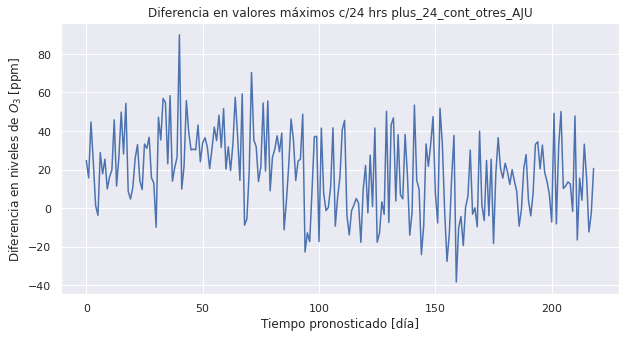

/tmp/ipykernel_1999599/3620498831.py:13: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  results_max_df = results_max_df.append(


plus_01_cont_otres_ATI
Error promedio al comparar valores máximos cada 24 hrs: -2.4754503351269346
Desviación estándar de diferencia en valores máximos diarios: 11.92812131977222


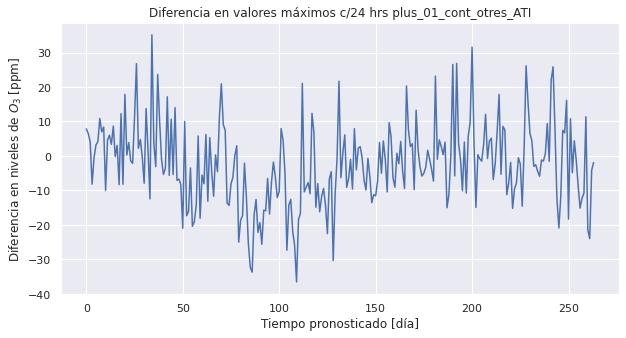

/tmp/ipykernel_1999599/3620498831.py:13: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  results_max_df = results_max_df.append(


plus_06_cont_otres_ATI
Error promedio al comparar valores máximos cada 24 hrs: -4.925750269925684
Desviación estándar de diferencia en valores máximos diarios: 15.345226558950747


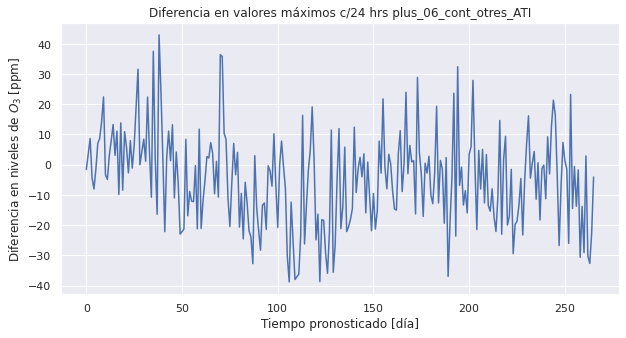

/tmp/ipykernel_1999599/3620498831.py:13: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  results_max_df = results_max_df.append(


plus_12_cont_otres_ATI
Error promedio al comparar valores máximos cada 24 hrs: -1.619067995171798
Desviación estándar de diferencia en valores máximos diarios: 15.425075668505476


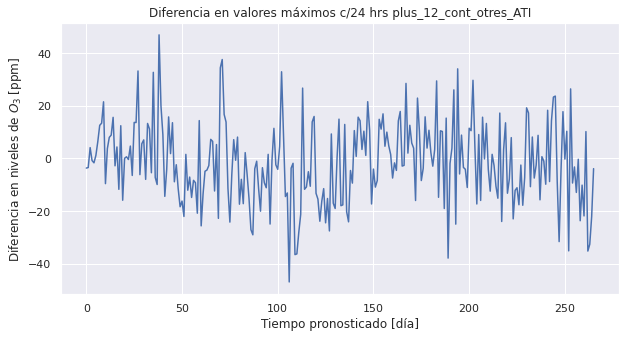

/tmp/ipykernel_1999599/3620498831.py:13: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  results_max_df = results_max_df.append(


plus_18_cont_otres_ATI
Error promedio al comparar valores máximos cada 24 hrs: -1.655563023405255
Desviación estándar de diferencia en valores máximos diarios: 14.869420469406775


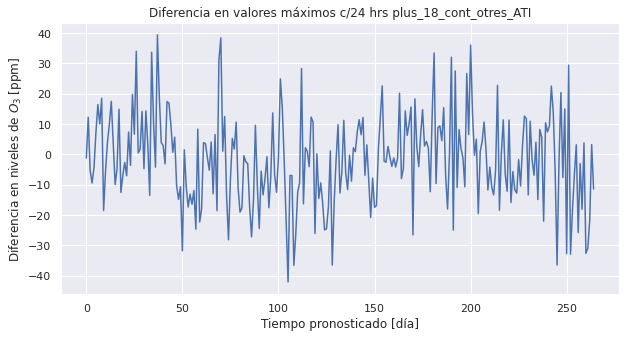

/tmp/ipykernel_1999599/3620498831.py:13: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  results_max_df = results_max_df.append(


plus_24_cont_otres_ATI
Error promedio al comparar valores máximos cada 24 hrs: -2.074051299185123
Desviación estándar de diferencia en valores máximos diarios: 16.69616789653224


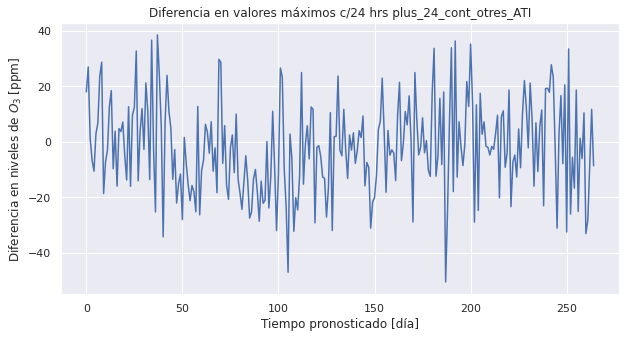

/tmp/ipykernel_1999599/3620498831.py:13: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  results_max_df = results_max_df.append(


plus_01_cont_otres_UAX
Error promedio al comparar valores máximos cada 24 hrs: -0.5553056928846571
Desviación estándar de diferencia en valores máximos diarios: 19.130953153262595


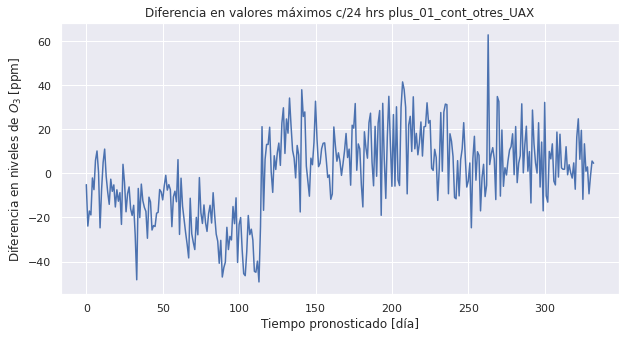

/tmp/ipykernel_1999599/3620498831.py:13: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  results_max_df = results_max_df.append(


plus_06_cont_otres_UAX
Error promedio al comparar valores máximos cada 24 hrs: -4.48596866973146
Desviación estándar de diferencia en valores máximos diarios: 22.13136065804443


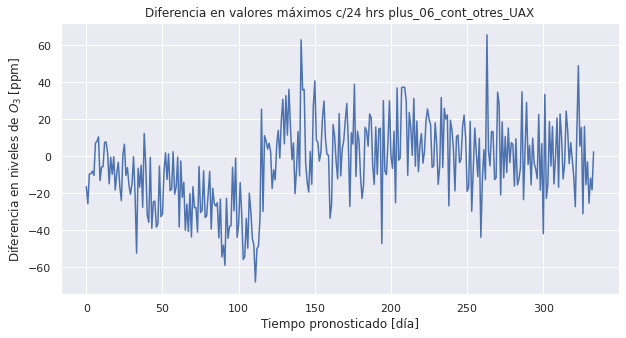

/tmp/ipykernel_1999599/3620498831.py:13: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  results_max_df = results_max_df.append(


plus_12_cont_otres_UAX
Error promedio al comparar valores máximos cada 24 hrs: 2.1829791239329746
Desviación estándar de diferencia en valores máximos diarios: 21.949869612925532


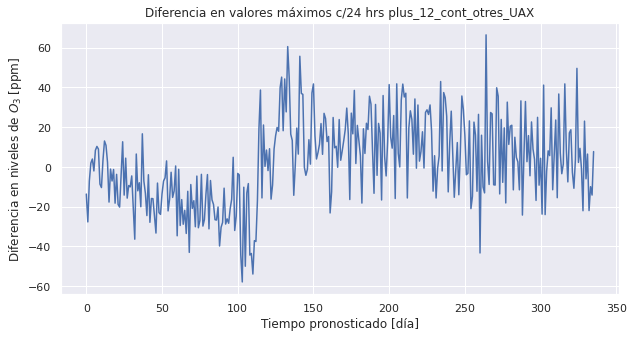

/tmp/ipykernel_1999599/3620498831.py:13: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  results_max_df = results_max_df.append(


plus_18_cont_otres_UAX
Error promedio al comparar valores máximos cada 24 hrs: 1.6789731289966996
Desviación estándar de diferencia en valores máximos diarios: 23.12042456895104


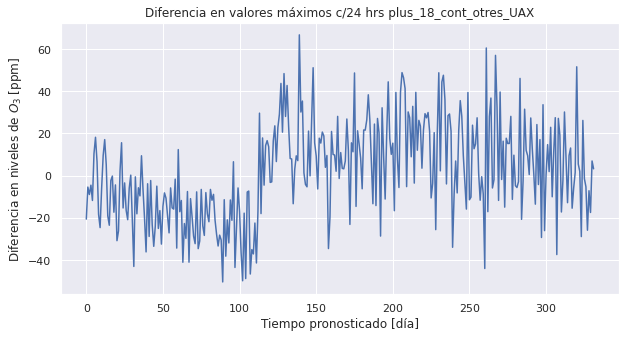

plus_24_cont_otres_UAX
Error promedio al comparar valores máximos cada 24 hrs: 1.2293030761880097
Desviación estándar de diferencia en valores máximos diarios: 24.04695319798662


/tmp/ipykernel_1999599/3620498831.py:13: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  results_max_df = results_max_df.append(


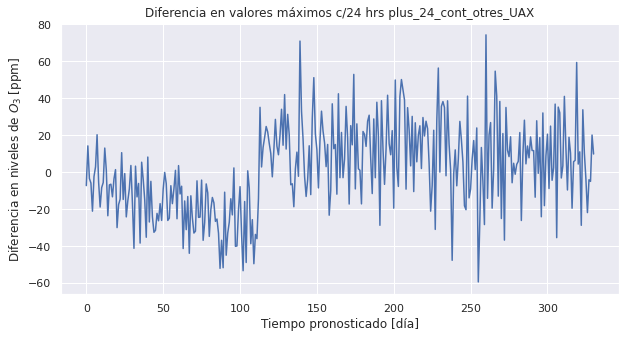

Promedio de h24_max_err_mean: 5.767376223308796
Promedio de h24_max_err_std: 18.198476425742214


/tmp/ipykernel_1999599/3620498831.py:13: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  results_max_df = results_max_df.append(


In [33]:
# %% Calculo de valores máximos por cada 24 horas. 
# Crear un DataFrame vacío

results_max_df = pd.DataFrame(columns=[
    'max_y_true', 'max_y_pred', 'h24_max_err_mean', 'h24_max_err_std'
])

# Rellenar el DataFrame con los resultados de la función
for cur_column in params_grid:
    print(cur_column)
    max_y_true, max_y_pred, h24_max_err_mean, h24_max_err_std = plot_max_difference(
        cur_column, y_true_df, y_pred_descaled_df)
    results_max_df = results_max_df.append(
        {
            'max_y_true': max_y_true,
            'max_y_pred': max_y_pred,
            'h24_max_err_mean': h24_max_err_mean,
            'h24_max_err_std': h24_max_err_std
        },
        ignore_index=True)

# Calcular el promedio de las cuatro columnas
average_h24_max_err_mean = results_max_df['h24_max_err_mean'].mean()
average_h24_max_err_std = results_max_df['h24_max_err_std'].mean()

print("Promedio de h24_max_err_mean:", average_h24_max_err_mean)
print("Promedio de h24_max_err_std:", average_h24_max_err_std)


In [34]:
# Inicializar nuevas columnas para almacenar los resultados adicionales
results_df['h24_max_err_mean'] = 0.0
results_df['h24_max_err_std'] = 0.0
results_df['h24_mean_err_mean'] = 0.0
results_df['h24_mean_err_std'] = 0.0
errors_dict = {}

# Iterar a través de cada fila en el DataFrame para actualizar las nuevas columnas
for index, row in results_df.iterrows():
    cur_column = row['Columna']
    # Llamar a la función plot_max_and_mean_difference y obtener los resultados
    max_y_true, max_y_pred, h24_max_err_mean, h24_max_err_std, mean_y_true, mean_y_pred, h24_mean_err_mean, h24_mean_err_std = plot_max_and_mean_difference(cur_column, y_true_df, y_pred_descaled_df)
    
    # Actualizar las nuevas columnas con los resultados obtenidos
    results_df.loc[index, 'h24_max_err_mean'] = h24_max_err_mean
    results_df.loc[index, 'h24_max_err_std'] = h24_max_err_std
    results_df.loc[index, 'h24_mean_err_mean'] = h24_mean_err_mean
    results_df.loc[index, 'h24_mean_err_std'] = h24_mean_err_std
    # Almacenar max_y_true, max_y_pred, mean_y_true, y mean_y_pred en el diccionario errors_dict
    errors_dict[cur_column] = {
        'max_y_true': max_y_true,
        'max_y_pred': max_y_pred,
        'mean_y_true': mean_y_true,
        'mean_y_pred': mean_y_pred
    }
# Ahora, results_df debería tener las nuevas columnas llenas con los resultados de la función

plus_01_cont_otres_UIZ
Maximum error mean over 24 hrs: 4.460710824546167
Maximum error std dev over 24 hrs: 13.149686857525953
Mean error mean over 24 hrs: 0.23318907466985392
Mean error std dev over 24 hrs: 4.362763527236729
plus_01_cont_otres_AJU
Maximum error mean over 24 hrs: 18.63933978361242
Maximum error std dev over 24 hrs: 17.70660436797239
Mean error mean over 24 hrs: 1.3212705318384763
Mean error std dev over 24 hrs: 6.0273385376124216
plus_01_cont_otres_ATI
Maximum error mean over 24 hrs: -2.4754503351269346
Maximum error std dev over 24 hrs: 11.92812131977222
Mean error mean over 24 hrs: -3.2950132061736754
Mean error std dev over 24 hrs: 3.506888200336712
plus_01_cont_otres_CUA
Maximum error mean over 24 hrs: 2.416933658830714
Maximum error std dev over 24 hrs: 16.439414198728677
Mean error mean over 24 hrs: 1.7381836218288838
Mean error std dev over 24 hrs: 5.29406186906549
plus_01_cont_otres_SFE
Maximum error mean over 24 hrs: 1.0499631450641267
Maximum error std dev ov

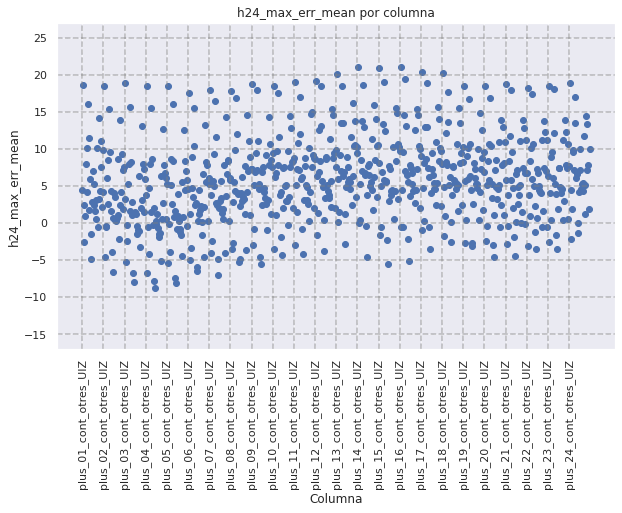

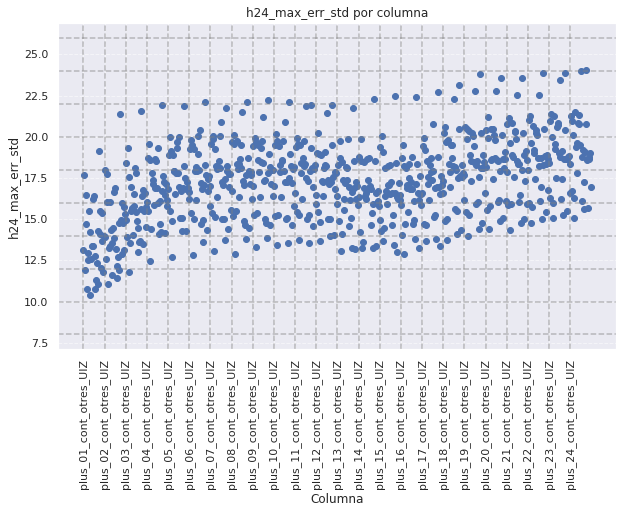

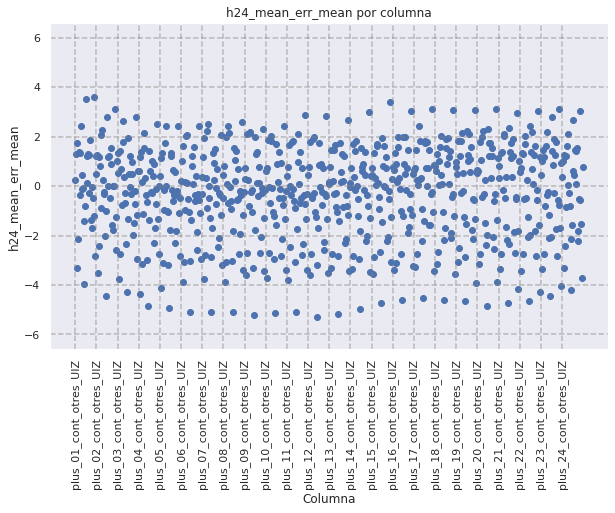

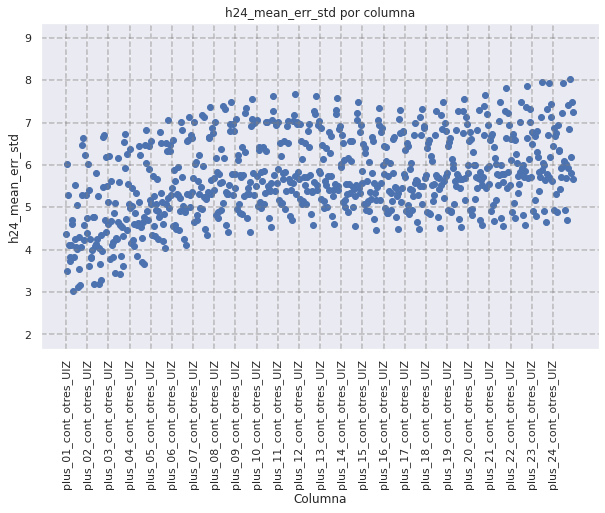

In [35]:
scatter_plot_by_column(results_df, 'h24_max_err_mean',
                output_results_folder_img)
scatter_plot_by_column(results_df, 'h24_max_err_std',
                output_results_folder_img)
scatter_plot_by_column(results_df, 'h24_mean_err_mean',
                output_results_folder_img)
scatter_plot_by_column(results_df, 'h24_mean_err_std',
                output_results_folder_img)

Promedio general de h24_max_err_mean sobre todas las estaciones: 5.7900


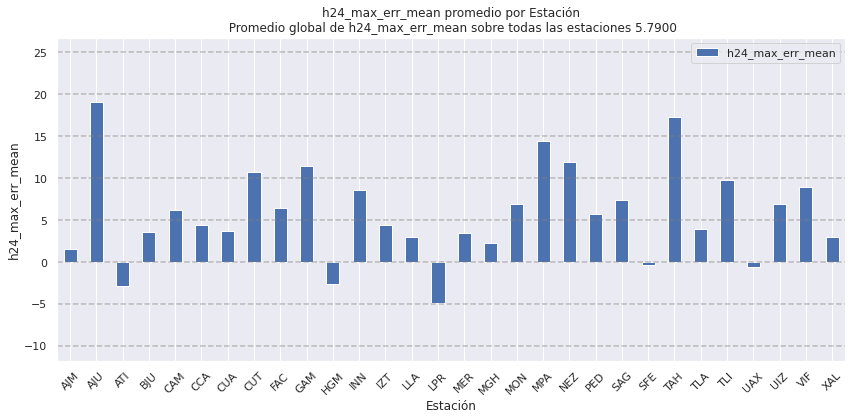

Promedio general de h24_max_err_std sobre todas las estaciones: 17.2496


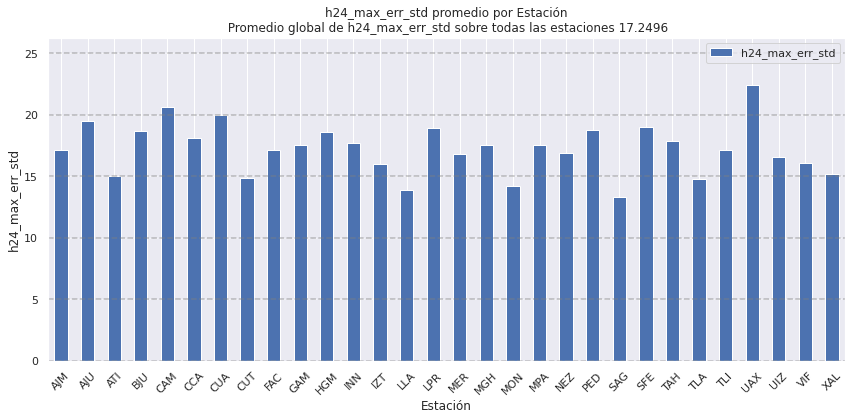

Promedio general de h24_mean_err_mean sobre todas las estaciones: -0.3219


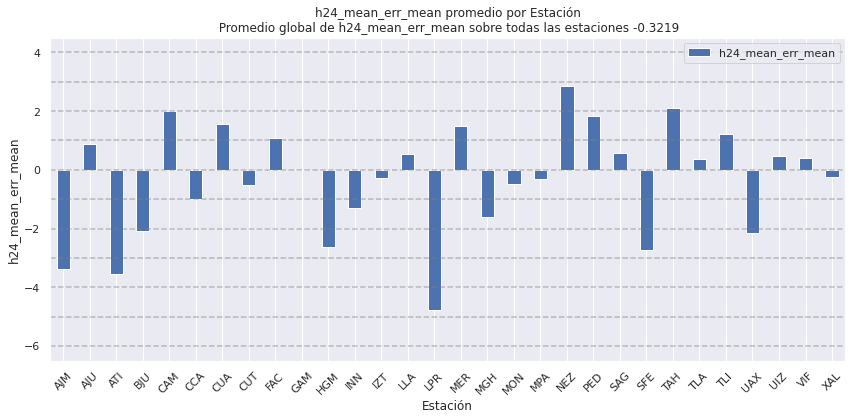

Promedio general de h24_mean_err_std sobre todas las estaciones: 5.7120


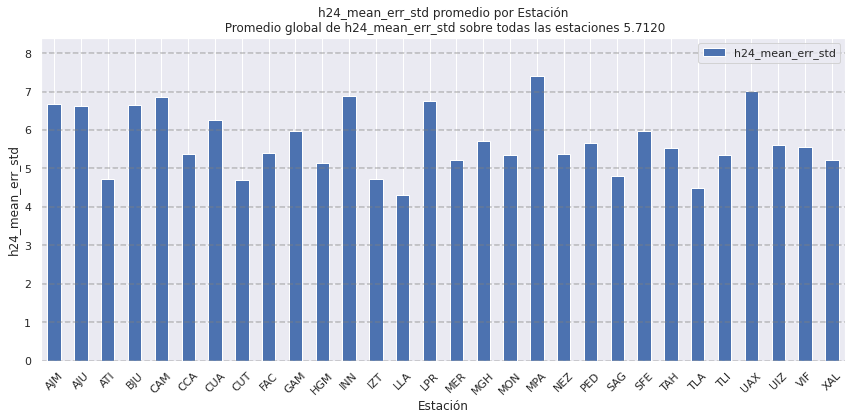

In [36]:
import warnings

with warnings.catch_warnings():
    warnings.simplefilter("ignore")
    # Tu código aquí callando warnings
    average_metric(results_df, 'h24_max_err_mean', output_results_folder_img)
    average_metric(results_df, 'h24_max_err_std', output_results_folder_img)
    average_metric(results_df, 'h24_mean_err_mean', output_results_folder_img)
    average_metric(results_df, 'h24_mean_err_std', output_results_folder_img)

Promedio general de h24_max_err_mean sobre todas las horas: 5.7900


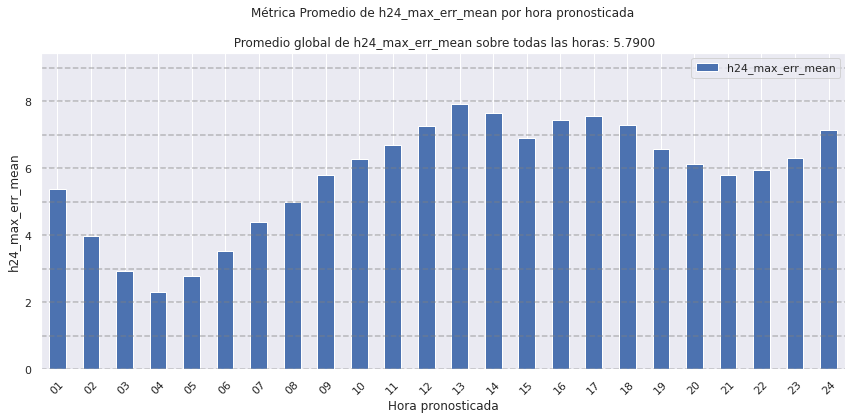

Promedio general de h24_max_err_std sobre todas las horas: 17.2496


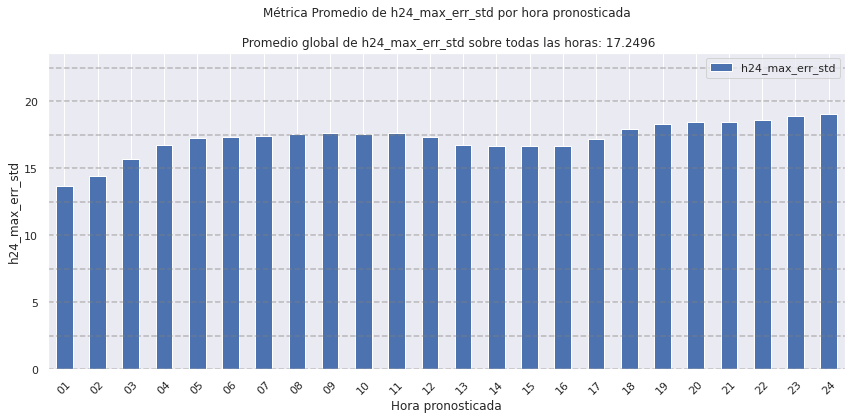

Promedio general de h24_mean_err_mean sobre todas las horas: -0.3219


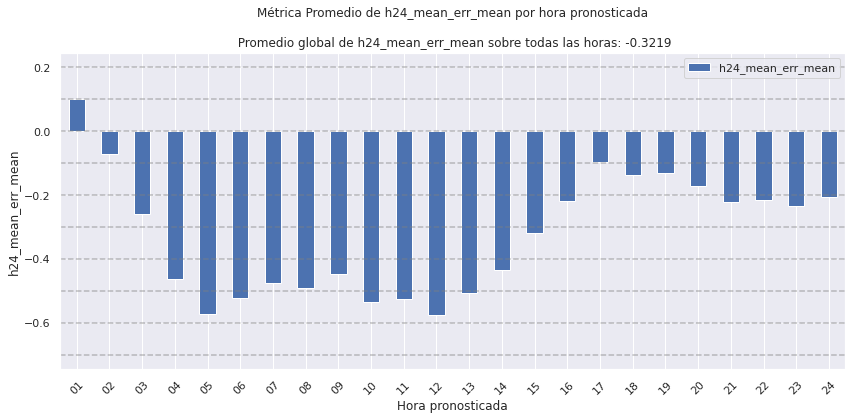

Promedio general de h24_mean_err_std sobre todas las horas: 5.7120


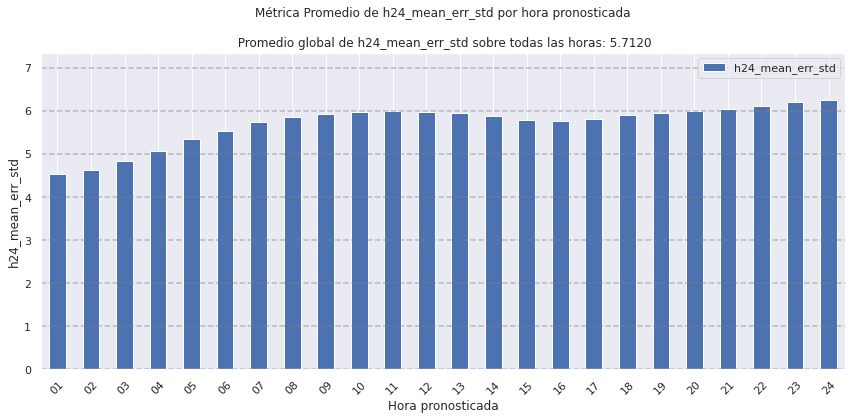

In [37]:

with warnings.catch_warnings():
    warnings.simplefilter("ignore")
    # Tu código aquí callando warnings
    average_metric_by_hour(results_df, 'h24_max_err_mean', output_results_folder_img)
    average_metric_by_hour(results_df, 'h24_max_err_std', output_results_folder_img)
    average_metric_by_hour(results_df, 'h24_mean_err_mean', output_results_folder_img)
    average_metric_by_hour(results_df, 'h24_mean_err_std', output_results_folder_img)

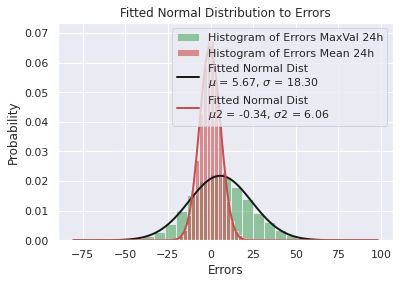

In [38]:
# Case for overall h24_max_err of the model

import numpy as np

from scipy.stats import norm


overall_errors = []

# Loop over the dictionary keys and values

for columna, values in errors_dict.items():

    max_y_true = values['max_y_true']

    max_y_pred = values['max_y_pred']

    errors = max_y_true - max_y_pred

    # Filtering out zeros

    for error in errors:

        if error != 0:

            overall_errors.append(error)


# Convert to numpy array for easier statistical analysis

overall_errors = np.array(overall_errors)


# Fit a normal distribution to the errors data

mu, std = norm.fit(overall_errors)


# Create a histogram of the errors

plt.hist(overall_errors, bins=25, density=True, alpha=0.6, color='g', label="Histogram of Errors MaxVal 24h")


# Create a PDF of the normal distribution

xmin, xmax = plt.xlim()

x = np.linspace(xmin, xmax, 100)

p = norm.pdf(x, mu, std)

overall_errors2 = []

# Loop over the dictionary keys and values

for columna, values in errors_dict.items():

    max_y_true = values['mean_y_true']

    max_y_pred = values['mean_y_pred']

    errors = max_y_true - max_y_pred

    # Filtering out zeros

    for error in errors:

        if error != 0:

            overall_errors2.append(error)


# Convert to numpy array for easier statistical analysis

overall_errors2 = np.array(overall_errors2)

plt.hist(overall_errors2, bins=25, density=True, alpha=0.6, color='r', label="Histogram of Errors Mean 24h")

mu2, std2 = norm.fit(overall_errors2)
p2 = norm.pdf(x, mu2, std2)


plt.plot(x, p, 'k', linewidth=2, label=f"Fitted Normal Dist\n$\mu$ = {mu:.2f}, $\sigma$ = {std:.2f}")
plt.plot(x, p2, 'r', linewidth=2, label=f"Fitted Normal Dist\n$\mu2$ = {mu2:.2f}, $\sigma2$ = {std2:.2f}")


plt.xlabel("Errors")

plt.ylabel("Probability")

plt.title("Fitted Normal Distribution to Errors")

plt.legend()

plt.show()

#mean_np, std_np, mu, std